# Spatial averaging for multi frequency IEC 62232 omni antenna
This notebook analyses scaled versions of the canonical panel antenna (without reflector plate) in the IEC 62232 standard for various frequencies

**Author**: Dr Vitas Anderson (*Two Fields Consulting*)

**Last updated**: 26/10/2023

+ The format of this notebook is based on the notebook for the Celwave PD620 omni antenna 
+ FEKO data provided by Danie Ludick
+ Antenna model is an omni consisting of nine vertical colinear dipoles which is based on the canonical panel antenna (without reflector plate) in the IEC 62232 standard. It has a relatively **narrow** vertical beam.
+ Modelled frequencies: **100, 300, 1000 & 3000** MHz
+ The FEKO models were appropriately scaled for each frequency
+ FEKO phantom uses the *amended* (trial 2) tissue dielectric values
+ Uses `RFcalcs_v01` module
+ Spatial averaging includes [Simpsons 1/3 Rule](https://2fc.gitbook.io/spatial-avg-wg/methodology/numerical-approaches-for-spatial-averaging#simpsons-one-third-rule) and [Gaussian Quadrature](https://pomax.github.io/bezierinfo/legendre-gauss.htmlhttps://pomax.github.io/bezierinfo/legendre-gauss.html) approaches
+ The 1.6m 17-point scheme using Simpsons 1/3 Rule is deemed the 'near-perfect' solution of the spatial average

![IEC 62232 omni antenna](../plots/iec62232-antenna-1000MHz-100WPavg.png)

## Load necessary python modules

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
from scipy.interpolate import interp1d
import altair as alt
from scipy import stats
from scipy import interpolate
from scipy import integrate
from collections.abc import Iterable
import textwrap as tr
import pandas as pd
from RFcalcs_v01 import *
pd.set_option('display.max_rows', 180)
from icecream import ic
from pprint import pprint
import seaborn as sns

# Set folder locations for antenna, plots and outputs
%cd -0
%cd ../
ANTDIR = './antennas/'
PLOTDIR = './antennas/omni2/plots/'
OUTDIR = './antennas/omni2/outputs/'

# Disable cell warnings (for seaborn warnings)
import warnings
warnings.filterwarnings('ignore')

# Set antenna parameters
POWER = 100      # nominal radiated power of the omni antennas
POWER_LOW = 0.5  # multiplier for low power level
POWER_HIGH = 2   # multiplier for high power level
FREQS = [100,300,1000,3000]
TRIALS = [10,11,12,13]

C:\Users\emeau\OneDrive\IT\Python\jupyter_notebooks\@Projects\spatial-averaging-wg\notebooks
C:\Users\emeau\OneDrive\IT\Python\jupyter_notebooks\@Projects\spatial-averaging-wg


In [3]:
Slimit(900, setting='pub', standard='RPS S-1 WB')

4.5

## Functions

In [4]:
def getgrid(df):
    '''Create a dataframe of a grid's characteristics:
       min, max, n, delta'''
    
    def n(arr):
        '''Return number of unique elements in array'''
        return arr.unique().size

    def max_delta(arr):
        '''Return dx or dz increment between x or z points'''
        return np.diff(np.sort(np.unique(arr))).max()
   
    grid = df[['x','z']].agg(['min','max',n,max_delta]).T
    grid['n'] = grid.n.astype(int)
    return grid

def dB(x):
    '''Return dB value of x'''
    return 10. * np.log10(x)

def omni_length(fMHz):
    '''Return the total length f the omni antenna'''
    wl = 300 / fMHz           # wavelength
    dipole_len = wl / 2       # dipole length
    dipole_sep = 0.75 * wl    # separation between dipole centres
    length = 3*dipole_sep + 4*dipole_len
    return length

def omni(fMHz, ax):
    # Draw omni antenna
    dipole_len = 0.158 * 900 / fMHz   # dipole length
    dipole_sep = 0.250 * 900 / fMHz   # separation between dipole centres
    zdcs = [dipole_sep * i for i in [-4,-3,-2,-1,0,1,2,3,4]]  # z for dipole centres
    
    for zdc in zdcs:
        zlow  = zdc - dipole_len / 2
        zhigh = zdc + dipole_len / 2
        ax.plot([0,0],[zlow,zhigh],'b-',lw=3)
        ax.plot(0,zdc,'ro',markersize=3)

def conv_vector(l, dl, m):
    '''Create a convolution vector
        l = length of convolution vector (m)
       dl = increment spacing between points in convolution vector (m)
        m = number of averaging points in convolution vector'''

    n = int(round(l/dl)) + 1  # number of points in convolution vector'''
    c = np.ones(n)            # convolution vector
    ix = np.arange(n)         # index of convolution vector
    dix = (n-1)/(m-1)         # index spacing between convolution averaging points

    assert round(l/dl,0) == round(l/dl,1), f'dl ({dl}) does not divide equally into l ({l})'
    assert type(m) == int, f'm ({m}) must be an integer'
    assert (n-1) % (m-1) == 0, f'm ({m}) does not distribute evenly across number of convolution points ({n})'

    c[(ix % dix) != 0] = 0
    c = c/m

    assert np.isclose(sum(c), 1, rtol=1e-08), f'sum of c ({sum(c)}) does not add up to 1'
    
    return c

def confunc(arr, Si, convector):
    """Returns numpy array for convolution transformation of S values
       Is used to do vertical spatial averaging
              Si = The column of S to be spatially averaged, e.g. Smax, Sfac, etc
       convector = the convolution vector, e.g. np.ones(21)/21 for 2 meter averaging 
                   with 0.1m intervals over 21 points
    """
    return np.convolve(arr[Si].values, convector, 'same')

def spatavg(df, name, Si, convector):
    """Creates a column in the S dataframe for spatially averaged field
       values in the z (i.e. vertical) orientation
            name = the name of the new column, e.g. 'Sfac_avg'
              Si = The column of S to be spatially averaged, e.g. Smax, Sfac, etc
       convector = the convolution vector for the spatial averaging, e.g. np.ones(21)/21 for 2 meter averaging
    """
    Savg = df[['x', 'y', Si]].groupby(['x', 'y']).apply(confunc, Si, convector, )
    Savg = np.concatenate(Savg.to_list())
        
    return Savg
    
def make_mgrid(df,c):
    '''Make an xz mgrid for column c'''
    df = df.sort_values(['x','z'])
    nx = len(df.x.unique())
    nz = len(df.z.unique())
    C = df[c].values.reshape(nx, nz)
    return C

def complot(df,t,setting,Ssa='Smax-1.6m-5',figsize=(6,4),
            axes=[],axi=0):
    '''Plot the compliance boundaries for Smax and SAR in xz plane
       and depict the omni antenna in the plot at x=0, z=0
       INPUTS:
           df = data dataframe containing x,y,z,Smax,Ssa,SAR data
           t = trial data from the spreadsheet, i.e. t = trialdata[trial]
           Ssa = Spatial average column name
           setting = seting for exposure limits ['pub' or 'occ']
           axes = matplotlib axes to plot to. Default of '[]' generates a new figure
           axi = index of axes to be plotted to
    '''
    
    # Get fMHz and power
    fMHz = t.fMHz
    power = t.Prad

    # Get S and SAR limit levels
    limS = Slimit(fMHz, setting=setting, standard='RPS S-1 WB')
    limSAR = SARlimit('pub')
    
    # make mgrids for x, z, S, SAR
    X = make_mgrid(df,'x')
    Z = make_mgrid(df,'z')
    Smax = make_mgrid(df,'Smax')
    Ssa = make_mgrid(df,Ssa)
    SAR = make_mgrid(df,'SARwbi')
    
    # Specify ax for the plot
    if len(axes) == 0:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        ax = np.array(axes).flatten()[axi]

    # Contour plots for S and SAR
    CS1 = ax.contour(X, Z, Smax, levels=[limS], colors=['green'], linewidths=0.6)
    CS2 = ax.contour(X, Z, SAR, levels=[limSAR], colors=['red'], linewidths=0.6)
    CS3 = ax.contour(X, Z, Ssa, levels=[limS], colors=['blue'], linewidths=0.6)

    # Add legend for contour plots
    h1,l1 = CS1.legend_elements()
    h2,l1 = CS2.legend_elements()
    h3,l1 = CS3.legend_elements()
    ax.legend([h1[0],h2[0],h3[0]], ['Smax', 'SAR', 'Ssa'])
    
    # Label axes and plot and display grid
    ax.set_xlabel("x (m)")
    ax.set_ylabel("z (m)")
    ax.set_xlim(left=0)
    ax.grid(ls='--')

    # Set plot title
    ax.set_title(f'{fMHz} MHz',fontsize=12,color='blue')
    
    # Add text for S and SAR limits
    text = f'{setting} limits:\n{limS} W/m²\n{limSAR} W/kg'
    ax.text(0.96, 0.15, text, horizontalalignment='right',verticalalignment='center',
            transform=ax.transAxes,fontsize=10, color='black',backgroundcolor='0.95')    

    # Draw omni antenna
    omni(fMHz, ax)
                
def complot2(df,t,setting,Scols='Smax-1.6m-5',figsize=(6,4),
            axes=None,axi=0):
    '''Plot the compliance boundaries for Smax and SAR in xz plane
       and depict the omni antenna in the plot at x=0, z=0
       INPUTS:
           df = data dataframe containing x,y,z,Smax,Ssa,SAR data
           t = trial data from the spreadsheet, i.e. t = trialdata[trial]
           Scols = S or SAR column name or list of names in df
           setting = seting for exposure limits ['pub' or 'occ']
           axes = matplotlib axes to plot to. Default of None generates a new figure
           axi = index of axes to be plotted to
    '''    
    # Get fMHz and power
    fMHz = t.fMHz
    power = t.Prad

    # Get S and SAR limit levels
    limS = Slimit(fMHz, setting=setting, standard='RPS S-1 WB')
    limSAR = SARlimit('pub')
    
    # Ensure Scols is an iterable
    if not isinstance(Scols, Iterable):
        Scols = [Scols]
        
    # Create legend labels
    coldict = {'SARwbi':'WBA SAR'}
    labels = [coldict[s] if s in coldict else s for s in Scols]    
        
    # Set applicable compliance limits
    limits = [limSAR if 'SAR' in Scol else limS for Scol in Scols]
        
    # Set color list
    colors = ['red','green','blue','purple','orange','brown']
    
    # Set linewidth, linestyle and alpha
    lw = [2 if Si=='Smax-1.6m-17-S13' else 0.6 for Si in Scols]
    ls = ['--' if Si=='Smax-1.6m-17-S13' else '-' for Si in Scols]
    alpha = [0.5 if Si=='Smax-1.6m-17-S13' else 1 for Si in Scols]

    # make mgrids for x, z and Scol columns
    X = make_mgrid(df,'x')
    Z = make_mgrid(df,'z')
    Sis = [make_mgrid(df,Scol) for Scol in Scols]
    
    # Specify ax for the plot
    if not isinstance(axes, Iterable):
        fig, ax = plt.subplots(figsize=figsize)
    else:
        ax = np.array(axes).flatten()[axi]

    # Contour plots for S and SAR
    CS = [ax.contour(X,Z,Si,levels=[limit],colors=colors.pop(0),linewidths=lw.pop(0),
                     alpha=alpha.pop(0),linestyles=ls.pop(0)) \
          for Si, limit in zip(Sis, limits)]
    h = [CSi.legend_elements()[0][0] for CSi in CS]
    ax.legend(h, labels)
    
    # Label axes and plot and display grid
    ax.set_xlabel("x (m)")
    ax.set_ylabel("z (m)")
    ax.set_xlim(left=0)
    ax.grid(ls='--')

    # Set plot title
    ax.set_title(f'{fMHz} MHz',fontsize=12,color='blue')
    
    # Add text for S and SAR limits
    text = f'{setting} limits:\n{limS} W/m²\n{limSAR} W/kg'
    ax.text(0.96, 0.15, text, horizontalalignment='right',verticalalignment='center',
            transform=ax.transAxes,fontsize=10, color='black',backgroundcolor='0.95')    

    # Draw omni antenna
    omni(fMHz, ax)
                
def GQRpoints(n, L):
    '''Calculates the points and weights for the Gauss Quadrature Rule
       over length L with points referenced to L's midpoint
       INPUTS:
         n = No. of GQR points
         L = integration length
       OUTPUTS:
         pts = integration points along L relative to center of L
         wts = weightings for each point'''
    match n:
        case 1:
            pts = np.array([0])
            wts = np.array([2])            
        case 2:
            p1 = 1/np.sqrt(3)
            pts = np.array([-p1,p1])
            w1 = 1
            wts = np.array([w1,w1])            
        case 3:
            p1 = np.sqrt(3/5)
            pts = np.array([-p1,0,p1])
            w0 = 8/9
            w1 = 5/9
            wts = np.array([w1,w0,w1])            
        case 4:
            p1 = np.sqrt(3/7 - 2/7*np.sqrt(6/5))
            p2 = np.sqrt(3/7 + 2/7*np.sqrt(6/5))
            pts = np.array([-p2,-p1,p1,p2])
            wt1 = (18 + np.sqrt(30)) / 36
            wt2 = (18 - np.sqrt(30)) / 36
            wts = np.array([wt2,wt1,wt1,wt2])            
        case 5:
            p1 = 1/3 * np.sqrt(5 - 2*np.sqrt(10/7))
            p2 = 1/3 * np.sqrt(5 + 2*np.sqrt(10/7))
            pts = np.array([-p2,-p1,0,p1,p2])
            w0 = 128/225
            w1 = (322 + 13*np.sqrt(70)) / 900
            w2 = (322 - 13*np.sqrt(70)) / 900
            wts = np.array([w2,w1,w0,w1,w2])
        case 6:
            p1 = 0.2386191860831969
            p2 = 0.6612093864662645
            p3 = 0.9324695142031521
            pts = np.array([-p3,-p2,-p1,p1,p2,p3])
            w1 = 0.4679139345726910
            w2 = 0.3607615730481386
            w3 = 0.1713244923791704
            wts = np.array([w3,w2,w1,w1,w2,w3])
        case 7:
            p1 = 0.4058451513773972
            p2 = 0.7415311855993945
            p3 = 0.9491079123427585
            pts = np.array([-p3,-p2,-p1,0,p1,p2,p3])
            w0 = 0.4179591836734694
            w1 = 0.3818300505051189
            w2 = 0.2797053914892766
            w3 = 0.1294849661688697
            wts = np.array([w3,w2,w1,w0,w1,w2,w3])
        case 8:
            p1 = 0.1834346424956498
            p2 = 0.5255324099163290
            p3 = 0.7966664774136267
            p4 = 0.9602898564975363
            pts = np.array([-p4,-p3,-p2,-p1,p1,p2,p3,p4])
            w1 = 0.3626837833783620
            w2 = 0.3137066458778873
            w3 = 0.2223810344533745
            w4 = 0.1012285362903763
            wts = np.array([w4,w3,w2,w1,w1,w2,w3,w4])    
        case 9:
            p1 = 0.8360311073266358
            p2 = 0.9681602395076261
            p3 = 0.3242534234038089
            p4 = 0.6133714327005904
            pts = np.array([-p4,-p3,-p2,-p1,0,p1,p2,p3,p4])
            w0 = 0.3302393550012598
            w1 = 0.1806481606948574
            w2 = 0.0812743883615744
            w3 = 0.3123470770400029
            w4 = 0.2606106964029354
            wts = np.array([w4,w3,w2,w1,w0,w1,w2,w3,w4])
        case _:
            raise Exception("No. of Gaussian Quadrature Points must be one of 1 to 9")
            
    pts = pts * L/2
    return pts, wts

def GQRsa(pts,wts,zps,Sps,zsa):
    '''Calculate the spatial average values using Gaussian Quadrature Rule
       INPUTS:
         pts = GQR point locations
         wts = GQR weights
         zps = z values for point spatial S estimates
         Sps = point spatial S values at zps locations
         zsa = z values where GQR spatial average estimates are evaluated
       OUTPUTS:
         Ssa = GQR spatial average estimates of S at zsa locations'''
    
    # Generate interpolation function for (zps, Sps) data
    f = interpolate.interp1d(zps, Sps, kind='cubic', fill_value='extrapolate')

    @np.vectorize
    def calcSsa(z):
        zGQR = z + pts
        SGQR = f(zGQR)
        S = (wts * SGQR).sum() / 2
        return S
    
    Ssa = calcSsa(zsa)
    
    return Ssa

def makegrid(df):
    grid = getgrid(df)
    grid.rename(columns={'max_delta':'increment'},inplace=True)
    return grid

def cbmask(df, Si, fMHz, lowp, highp):
    '''Returns a mask for df for points between low power occ
       and high power pub compliance boundaries
       INPUTS:
         df = S data dataframe
         Si = column name for S level
         fMHz = exposure frequency in MHz
         lowp = low power level as fraction of simulation power level
         highp = high power level as fraction of simulation power level
    '''
    # Get pub and occ S limit levels
    limSpub = Slimit(fMHz, setting='pub', standard='RPS S-1 WB')
    limSocc = Slimit(fMHz, setting='occ', standard='RPS S-1 WB')
    
    # Calculate low and high S levels
    Slow = limSpub / highp
    Shigh = limSocc / lowp
    # print(f'{Slow=}, {Shigh=}')
    
    # Create mask
    mask = (df.fMHz == fMHz) & (df[Si] > Slow) & (df[Si] < Shigh)
    
    return mask

def Rpoints(ax, df, Si, fMHz, power_low=1, power_high=1,
            cbflag=False,ptsize=1,vmin=-4,vmax=4):
    '''Generate contour plots of df[Si] in xz plane for:
         + low power occ limit boundary
         + high power pub limit boundary
       Also show assessment points between these boundaries
       Colour the points according to their dB(R) value
       Depict the omni antenna in the plot at x=0, z=0
       INPUTS:
         df = data dataframe containing x,y,z,Smax,Ssa,SAR data
         trial = trial number
         Si = S data column name in df for generating contours, e.g. "Smax-1.6m-5-S13"        
         fMHz = frequency of the exposure in MHz)
         power_low = lower antenna power as a fraction of simulation power
         power_high = upper antenna power as a fraction of simulation power
         cbflag = flag as to whether or not display the colorbar
    '''
    
    # Calculate limit values
    limSpub = Slimit(fMHz, setting='pub', standard='RPS S-1 WB')
    limSocc = Slimit(fMHz, setting='occ', standard='RPS S-1 WB')
    # print(f'{t.fMHz} MHz: S pub limit = {limSpub} W/m², S occ limit = {limSocc} W/m²')
    
    # Calculate contour levels
    level_low = limSpub / power_high
    level_high = limSocc / power_low
    # print(f'{level_low = }, {level_high = }')

    # filter df for rows containing fMHz
    df = df[df.fMHz == fMHz]
    
    # make mgrids for x, z, S, SAR
    X = make_mgrid(df,'x')
    Z = make_mgrid(df,'z')
    C = make_mgrid(df,Si)

    # set mask for points between points mask for trial
    mask = cbmask(df, Si, fMHz, power_low, power_high)      
        
    # Create plot title
    title = f'{Si} ({fMHz} MHz)\n{level_low=}, {level_high=}'
    
    # Contour plots for R
    CS = ax.contourf(X, Z, C, levels=[level_low,level_high], alpha=0.2)
    
    # Scatter plot of assessment point locations, coloured by dB(R) level
    dBRcol = f'dBR_{Si}'
    df[mask].plot.scatter('x','z',ax=ax,s=ptsize,c=dBRcol,title=f'{fMHz} MHz',
                          colorbar=cbflag,cmap='bwr',vmin=-4,vmax=4)

    # Label axes and plot and display grid
    ax.set_xlabel("x (m)")
    ax.set_ylabel("z (m)")
    ax.set_xlim(left=0)
    ax.grid(ls='--')
    
    # Draw omni antenna
    omni(fMHz, ax)

## Look at model metadata for the spatial averaging trials

In [5]:
# Read in model set up data from "calc uc trials.xls" spreadsheet
trialdata = pd.read_excel(ANTDIR + 'spat avg trials.xlsx', 'trials', 
                          skiprows=1, index_col=0).fillna('')
trialdata.drop("unit", axis=1, inplace=True)
trialdata.columns = [int(col) for col in trialdata.columns]

# Show model data for PD620 omni trials
trialdata.loc[:,TRIALS]

,10,11,12,13
INPUT,,,,
fMHz,100,300,1000,3000
antenna,Omni,Omni,Omni,Omni
Prad,100,100,100,100
dBiGain,13.5,13.5,13.5,13.5
horizHPBW,,,,
vertHPBW,,,,
coordinate_origin,centre of omni,centre of omni,centre of omni,centre of omni
xstart,0.025,0.025,0.025,0.025
xend,20.025,20.005,10.005,10.025


## ++ JUMP TO LOAD Sall ++

## Read in the E and H data from the FEKO zip files

### S: FEKO S values

In [6]:
# Get the trial frequencies
freqs = trialdata.loc['fMHz',TRIALS].values.tolist()

# Create empty data frame for S data
S = pd.DataFrame(columns=['trial','fMHz','x','y','z','wtx','SE','SH','Smax'])
S = S.astype({'trial':int,'fMHz':float})

# Get S data for each trial
for trial in TRIALS:
    # Get E and H FEKO data file locations
    t = trialdata[trial]
    datadir = f'./antennas/{t.antenna_folder}/data/'
    Efile = t.FEKO_Efile
    Hfile = t.FEKO_Hfile
    print(f'{t.fMHz} MHz')
    
    # Read in E-field FEKO data
    print(f'{  Efile = }')
    Enames = ['x','y','z','Exr','Exi','Eyr','Eyi','Ezr','Ezi']
    Edat = pd.read_csv(datadir + Efile, sep='\s+', skiprows=17, names=Enames)
    Edat = Edat.sort_values(['x','z'])

    # Read in H-field FEKO data
    print(f'{  Hfile = }')
    Hnames = ['x','y','z','Hxr','Hxi','Hyr','Hyi','Hzr','Hzi']
    Hdat = pd.read_csv(datadir + Hfile, sep='\s+', skiprows=17, names=Hnames)
    Hdat = Hdat.sort_values(['x','z'])

    # Calculate SE, SH, Smax
    SE = 0.5 * Edat.loc[:,'Exr':'Ezi'].pow(2).sum(axis=1) / 377
    SH = 0.5 * Hdat.loc[:,'Hxr':'Hzi'].pow(2).sum(axis=1) * 377
    Smax = np.max([SE,SH],axis=0)

    # Create trial dataframe
    Strial = pd.DataFrame(dict(trial=trial,fMHz=t.fMHz,x=Edat.x,y=Edat.y,z=Edat.z,
                               SE=SE,SH=SH,Smax=Smax)).reset_index(drop=True)
    
    # Append Strial to S dataframe
    S = pd.concat([S,Strial])

100 MHz
  Efile = 'iec62232_omni_100MHz_100W_0.02m_sampling_NearField.efe.zip'
  Hfile = 'iec62232_omni_100MHz_100W_0.02m_sampling_NearField.hfe.zip'
300 MHz
  Efile = 'iec62232_omni_300MHz_100W_0.02m_sampling_NearField.efe.zip'
  Hfile = 'iec62232_omni_300MHz_100W_0.02m_sampling_NearField.hfe.zip'
1000 MHz
  Efile = 'iec62232_omni_1000MHz_100W_0.02m_sampling_NearField.efe.zip'
  Hfile = 'iec62232_omni_1000MHz_100W_0.02m_sampling_NearField.hfe.zip'
3000 MHz
  Efile = 'iec62232_omni_3000MHz_100W_0.02m_sampling_NearField.efe.zip'
  Hfile = 'iec62232_omni_3000MHz_100W_0.02m_sampling_NearField.hfe.zip'


In [7]:
# Show first 5 rows of S dataframe
S.head()

,trial,fMHz,x,y,z,wtx,SE,SH,Smax
0,10,100.0,0.025,0.0,-20.00,NaN,0.000014,9.414587e-09,0.000014
1,10,100.0,0.025,0.0,-19.98,NaN,0.000014,9.487741e-09,0.000014
2,10,100.0,0.025,0.0,-19.96,NaN,0.000014,9.561609e-09,0.000014
3,10,100.0,0.025,0.0,-19.94,NaN,0.000014,9.636201e-09,0.000014
4,10,100.0,0.025,0.0,-19.92,NaN,0.000014,9.711525e-09,0.000014


In [8]:
# Check data types in S
S.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4403000 entries, 0 to 200499
Data columns (total 9 columns):
 #   Column  Dtype  
---  ------  -----  
 0   trial   int64  
 1   fMHz    float64
 2   x       float64
 3   y       float64
 4   z       float64
 5   wtx     object 
 6   SE      float64
 7   SH      float64
 8   Smax    float64
dtypes: float64(7), int64(1), object(1)
memory usage: 335.9+ MB


In [9]:
# Show S grid paramters grouped by fMHz
S.groupby('fMHz').apply(makegrid)

min     max     n  increment
fMHz                                     
100.0  x   0.025  20.005  1000       0.02
       z -20.000  20.000  2001       0.02
300.0  x   0.025  20.005  1000       0.02
       z -20.000  20.000  2001       0.02
1000.0 x   0.025  10.005   500       0.02
       z  -4.000   4.000   401       0.02
3000.0 x   0.025  10.005   500       0.02
       z  -4.000   4.000   401       0.02

### Reduce size of xz grid in S

In [10]:
# Drop values where x > 5m
mask = (S.x > 5)
S = S[~mask]

# Drop values for z > specified level
mask = ((S.fMHz == 100.) & (S.z.abs() > 16)) | \
       ((S.fMHz == 300.) & (S.z.abs() > 8)) | \
       ((S.fMHz == 1000.) & (S.z.abs() > 4)) | \
       ((S.fMHz == 3000.) & (S.z.abs() > 3))
S = S[~mask]

In [11]:
# Show S grid paramters grouped by fMHz
S.groupby('fMHz').apply(makegrid)

min     max     n  increment
fMHz                                     
100.0  x   0.025   4.985   249       0.02
       z -16.000  16.000  1601       0.02
300.0  x   0.025   4.985   249       0.02
       z  -8.000   8.000   801       0.02
1000.0 x   0.025   4.985   249       0.02
       z  -4.000   4.000   401       0.02
3000.0 x   0.025   4.985   249       0.02
       z  -3.000   3.000   301       0.02

### Calculate x-weightings
(for 2D planar to 3D volumetric distributions)

In [12]:
S['wtx'] = (S.x*100).astype(int)

## Get SAR data

### SARdf0: FEKO SAR data

In [13]:
# Create empty SARdf0 dataframe
SARdf0 = pd.DataFrame(columns=['trial','fMHz','x','y','z','SARwb'])
SARdf0 = SARdf0.astype({'trial':int,'fMHz':float})

# Combine SAR data from FEKO files into SARdf0 dataframe
for trial in TRIALS:
    t = trialdata[trial]  # trial data
    datadir = f'{ANTDIR}{t.antenna_folder}/data/'
    
    # Read in .csv SAR data file
    SARdftrial = pd.read_csv(datadir + t.SAR_file, usecols=[0,1,2,4]).astype(float)
    SARdftrial.columns = ['x','y','z','SARwb']
    SARdftrial['trial'] = trial
    SARdftrial['fMHz'] = t.fMHz
    
    # Concatenate SARdftrial to SARdf0
    SARdf0 = pd.concat([SARdf0,SARdftrial],ignore_index=True,verify_integrity=True)
    
    # Print unique values in x,y,z, columns
    print(f'{t.fMHz} MHz: {t.SAR_file} ')
    print('x values:', *SARdftrial.x.unique())
    print('y values:', *SARdftrial.y.unique())
    print('z values:', *SARdftrial.z.unique(), '\n')

# Replace zero SAR values with 5E-6
SARdf0['SARwb'] = SARdf0['SARwb'].replace(0, 5E-6) 

# Display SARdf0 rows where z=0
SARdf0.query("z==0")

100 MHz: wbSAR-100MHz-IEC62232-monopole.csv 
x values: 0.05 0.1 0.3 0.6 1.0 1.5 2.2 3.0 3.9 5.0 6.2 7.5
y values: 0.0
z values: -15.0 -12.0 -9.0 -6.0 -4.0 -2.5 -1.7 -1.0 -0.5 0.0 0.5 1.0 1.7 2.5 4.0 6.0 9.0 12.0 15.0 

300 MHz: wbSAR-300MHz-IEC62232-monopole.csv 
x values: 0.05 0.1 0.3 0.6 1.0 1.5 2.2 3.0 3.9 5.0 6.2 7.5
y values: 0.0
z values: -15.0 -12.0 -9.0 -6.0 -4.0 -2.5 -1.7 -1.0 -0.5 0.0 0.5 1.0 1.7 2.5 4.0 6.0 9.0 12.0 15.0 

1000 MHz: wbSAR-1000MHz-IEC62232-monopole-all.csv 
x values: 0.05 0.1 0.3 0.6 1.0 1.5 2.2 3.0 4.0 5.0
y values: 0.0
z values: -3.8 -3.0 -2.3 -1.6 -1.0 -0.5 0.0 0.5 1.0 1.6 2.3 3.0 3.8 -0.75 -0.25 0.25 0.75 

3000 MHz: wbSAR-3000MHz-IEC62232-monopole-all.csv 
x values: 0.05 0.07 0.1 0.2 0.3 0.6 1.0 1.5 2.2 3.0 4.0 5.0
y values: 0.0
z values: -2.0 -1.5 -1.0 -0.5 0.0 0.5 1.0 1.5 2.0 -0.2 0.2 



,trial,fMHz,x,y,z,SARwb
9,10,100.0,0.05,0.0,0.0,0.288290
28,10,100.0,0.10,0.0,0.0,0.356500
47,10,100.0,0.30,0.0,0.0,0.175030
66,10,100.0,0.60,0.0,0.0,0.052629
85,10,100.0,1.00,0.0,0.0,0.023900
104,10,100.0,1.50,0.0,0.0,0.019628
123,10,100.0,2.20,0.0,0.0,0.013986
142,10,100.0,3.00,0.0,0.0,0.010238
161,10,100.0,3.90,0.0,0.0,0.007841
180,10,100.0,5.00,0.0,0.0,0.006157


### Interpolation functions

In [14]:
def axisvals(axis, delta, df):
    '''Generate points for axis in df for delta increment'''
    minval = df[axis].min()
    maxval = df[axis].max()
    return np.arange(minval, maxval+delta, delta).round(8)

def SARinterpolator1d(df, ax1, newaxisvals, kind):
    '''Interpolate SARwb values in df along specified x, y or z axis
    INPUTS:
      df = input dataframe
      ax1 = axis to intepolate along ['x', 'y' or 'z']
      newaxisvals = interpolation points along the ax1 axis
      kind = type of interpolation [linear, quadractic, cubic, etc]
    OUTPUTS:
      df1 = dataframe with interpolated SARwb values
      '''
    print(f'{kind} log interpolation along the {ax1} axis ...')
    
    # Get axis names for ax2, ax3
    other_axes = dict(x=('y','z'),y=('x','z'),z=('x','y'))
    ax2, ax3 = other_axes[ax1]
    
    # Create empty dataframe
    df1 = pd.DataFrame(columns=('x','y','z','SARwb')) # initialise empty dataframe
    
    # Groupby over ax2 and ax3 axes
    for (ax2val,ax3val), g in df.groupby([ax2, ax3]):
        
        # get xx, yy interpolation arrays and remove elements where yy is nan 
        xx = g[ax1].values.astype(np.float64)
        yy = g.SARwb.values.astype(np.float64)
        mask = np.isnan(yy)
        xx = xx[~mask]
        yy = yy[~mask]
        if 0 in yy:
            print(f'{ax2}={ax2val}, {ax3}={ax3val}')
            print(yy)           
        yy = np.log10(yy)
        
        # Create 1d interpolation function
        f = interp1d(xx, yy, kind=kind, fill_value='extrapolate')
        ff = lambda newaxisvals: 10**f(newaxisvals)
    
        # do interpolation over ax1 axis
        SARwb = ff(newaxisvals)
        dfi = pd.DataFrame({ax1:newaxisvals, ax2:ax2val, ax3:ax3val, 'SARwb':SARwb})
        df1 = pd.concat([df1, dfi])
        
    df1 = df1.sort_values(['x','y','z']).reset_index(drop=True)
    return df1.astype(float)

### SARdfi_all: Interpolate SARdf0 over x & z axes

In [15]:
# Create empty SAR dataframe
SARdfi_all = pd.DataFrame(columns=['x','y','z','SARwbi','trial'])
SARdfi_all = SARdfi_all.astype({'trial':int})

for trial in TRIALS:
    t = trialdata[trial]
    fMHz = t.fMHz
    print(f'\n{fMHz} MHz')
    Strial = S[S.trial == trial]
    SARtrial = SARdf0[SARdf0.trial == trial]

    # Set interpolation parameters
    xnew = axisvals('x', t.dx, Strial)  # new x-value interpolation points
    znew = axisvals('z', t.dz, Strial)  # new z-value interpolation points

    # Conduct x, y and z axis interpolations
    SARdfi_x = SARinterpolator1d(SARtrial,'x',xnew,'quadratic')
    SARdfi_xz = SARinterpolator1d(SARdfi_x,'z',znew,'quadratic')

    # Rename SARwb to SARwbi
    SARdfi_xz.rename(columns={'SARwb':'SARwbi'},inplace=True)    
    
    # Add trial & fMHz column
    SARdfi_xz['trial'] = trial
    SARdfi_xz['fMHz'] = fMHz
    # display(SARdfi_xz)
    
    # Concatenate trial data to SARdfi_all
    SARdfi_all = pd.concat([SARdfi_all, SARdfi_xz])


100 MHz
quadratic log interpolation along the x axis ...
quadratic log interpolation along the z axis ...

300 MHz
quadratic log interpolation along the x axis ...
quadratic log interpolation along the z axis ...

1000 MHz
quadratic log interpolation along the x axis ...
quadratic log interpolation along the z axis ...

3000 MHz
quadratic log interpolation along the x axis ...
quadratic log interpolation along the z axis ...


In [16]:
SARdfi_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 772896 entries, 0 to 74948
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   x       772896 non-null  float64
 1   y       772896 non-null  float64
 2   z       772896 non-null  float64
 3   SARwbi  772896 non-null  float64
 4   trial   772896 non-null  int64  
 5   fMHz    772896 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 41.3 MB


In [17]:
# Get SAR grid parameters
SARdfi_all.groupby('fMHz').apply(makegrid)

min     max     n  increment
fMHz                                     
100.0  x   0.025   4.985   249       0.02
       z -16.000  16.000  1601       0.02
300.0  x   0.025   4.985   249       0.02
       z  -8.000   8.000   801       0.02
1000.0 x   0.025   4.985   249       0.02
       z  -4.000   4.000   401       0.02
3000.0 x   0.025   4.985   249       0.02
       z  -3.000   3.000   301       0.02

### Check symmetry of SARdfi_all in the z direction

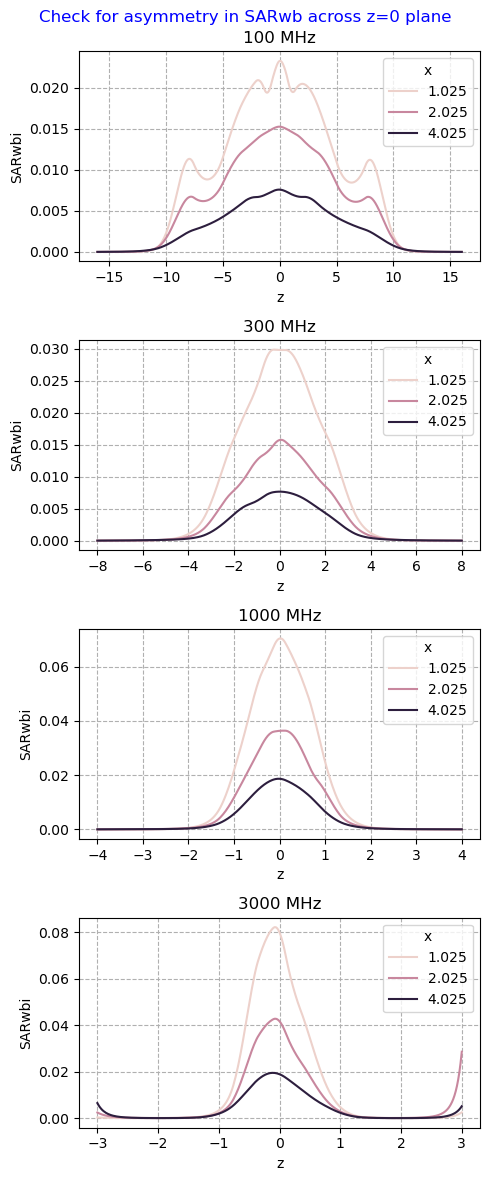

In [18]:
# Bar plots of dB(SARwb) along z for various values of x and y
SARdfi = SARdfi_all.copy()
SARdfi['dB(SARwbi)'] = dB(SARdfi.SARwbi)
xvals = [1.025,2.025,4.025]

fig, ax = plt.subplots(len(TRIALS),1,figsize=(5,12))
plt.suptitle(f"Check for asymmetry in SARwb across z=0 plane",fontsize=12,c='b')

for i, trial in enumerate(TRIALS):
    mask = (SARdfi.x.isin(xvals)) & (SARdfi.trial==trial)
    t = trialdata[trial]
    sns.lineplot(SARdfi[mask],x='z',y='SARwbi',hue='x',ax=ax[i])
    ax[i].set_title(f'{t.fMHz} MHz')
    ax[i].grid(ls='--')
    
plt.tight_layout();

Data looks nicely symmetric in the z axis, except very close to the antenna. It is *not* expected to be perfectly symmetric since the body phantom is not totally symmetric in the z direction

### Sall: Merge S with SARdfi_all
*Don't* merge in **SARdfall** since some of the SARwb points, e.g. y=0.36, x=0.81, are not on the 0.1m grid spacing

In [19]:
# Create Sall by merging SARwb and SARps from SARdf with S dataframe
Sall = S.merge(SARdfi_all,how='left',on=['trial','fMHz','x','y','z']).sort_values(['trial','x','y','z'],ignore_index=True)
Sall.head()

,trial,fMHz,x,y,z,wtx,SE,SH,Smax,SARwbi
0,10,100.0,0.025,0.0,-16.00,2,0.000097,6.644444e-08,0.000097,0.000004
1,10,100.0,0.025,0.0,-15.98,2,0.000098,6.728269e-08,0.000098,0.000004
2,10,100.0,0.025,0.0,-15.96,2,0.000099,6.813409e-08,0.000099,0.000004
3,10,100.0,0.025,0.0,-15.94,2,0.000100,6.899887e-08,0.000100,0.000004
4,10,100.0,0.025,0.0,-15.92,2,0.000102,6.987729e-08,0.000102,0.000004


### Show xyz grid values of Sall

In [20]:
# Show xyz grid values for Sall
Sall.groupby('fMHz').apply(getgrid)

min     max     n  max_delta
fMHz                                     
100.0  x   0.025   4.985   249       0.02
       z -16.000  16.000  1601       0.02
300.0  x   0.025   4.985   249       0.02
       z  -8.000   8.000   801       0.02
1000.0 x   0.025   4.985   249       0.02
       z  -4.000   4.000   401       0.02
3000.0 x   0.025   4.985   249       0.02
       z  -3.000   3.000   301       0.02

## Calculate spatial averages

### Simple averages

In [21]:
# Set parameters
l, dl = 1.6, 0.02
mlist = [5,9,17]

# Set convolution vectors for 1.6m
clist = [conv_vector(l, dl, m) for m in mlist]
for m, c in zip(mlist,clist):
    print(f'{m:3d} points:\nsum{list(c.round(3))} = {sum(c)}')

# Create spatial averages for SE and Smax for clist items
print()
for Si in ['Smax', 'SE']:
    for m, c in zip(mlist,clist):
        print(f'creating {m}-point spatial averages of {Si}')
        sa_all = np.empty(0)
        for trial in TRIALS:
            mask = Sall.trial == trial
            name = f"{Si}-{l}m-{m}"
            sa = spatavg(Sall[mask], name, Si,  c)
            sa_all = np.concatenate([sa_all,sa])
        Sall[name] = sa_all

  5 points:
sum[0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2] = 1.0
  9 points:
sum[0.111, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.111, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.111, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.111, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.111, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.111, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.111, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.111, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.111] = 1.0000000000000002
 17 points:
sum[0.059, 0.0, 0.0, 0.0, 0.0, 0.059, 0.0, 0.0, 0.0, 0.0, 0.059, 0.0, 0.0, 0.0, 0.0, 0.059, 0.0, 0.0,

### Simpsons 1/3 rule

In [22]:
def con_vector_S13(l, dl, m):
    '''Create convolution vector for Simpsons 1/3 rule
    INPUTS:
      l = averaging length
      dl = increment between points
      m = number of points
    OUTPUT:
      c = convolution vector
      '''
    n = int(round(l/dl)+1)  # no. of elements in convolution vector
    n_zeros = int(round((n-m)/(m-1)))  # no. of zeros in gaps between weights
    wts = [4,2]*100         # a pop list for the weights
    
    # Assemble the convolution vector
    c = np.zeros(n)  # create the initial vector       
    c[0] = 1
    c[-1] = 1
    ix = 0
    for i in range(m-2):
        ix += n_zeros + 1
        c[ix] = wts.pop(0)
    c = c / sum(c)
    return c

In [23]:
# Set parameters
l, dl = 1.6, 0.02
mlist = [5,9,17]

# Generate convolution vectors for Simpsons 1/3 rule
clistS13 = [con_vector_S13(l,dl,m) for m in mlist]
for m, c in zip(mlist,clistS13):
    print(f'{m:3} points:\nsum{list(c.round(3))} = {sum(c):0.4f}')

# Create spatial averages for SE and Smax clistS13 items
for Si in ['Smax', 'SE']:
    for m, c in zip(mlist,clistS13):
        print(f'creating {m}-point S13 spatial averages of {Si}')
        sa_all = np.empty(0)
        for trial in TRIALS:
            mask = Sall.trial == trial
            name = f"{Si}-{l}m-{m}-S13"
            sa = spatavg(Sall[mask], name, Si,  c)
            sa_all = np.concatenate([sa_all,sa])
        Sall[name] = sa_all

  5 points:
sum[0.083, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.167, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.083] = 1.0000
  9 points:
sum[0.042, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.167, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.083, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.167, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.083, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.167, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.083, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.167, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.042] = 1.0000
 17 points:
sum[0.021, 0.0, 0.0, 0.0, 0.0, 0.083, 0.0, 0.0, 0.0, 0.0, 0.042, 0.0, 0.0, 0.0, 0.0, 0.083, 0.0, 0.0

### Gaussian Quadrature

In [24]:
# Set convolution vectors for 1.6m and Gaussian Quadrature
L = 1.6
mlist = (3,4,5,7,8,9)
clistGQ = [GQRpoints(m, L) for m in mlist]

# Create spatial averages for SE and Smax Gaussian quadrature
for Si in ['Smax', 'SE']:
    print(Si)
    for m, (pts,wts) in zip(mlist,clistGQ):
        print(f'  {m}-point GQ spatial averages')
        sa_all = np.empty(0)
        for trial in TRIALS:
            SGQ = Sall[Sall.trial == trial]
            name = f"{Si}-{l}m-{m}-GQ"
            for xname, g in SGQ.groupby('x'):
                sa = GQRsa(pts,wts,g.z.values,g[Si].values,g.z.values)
                sa_all = np.concatenate([sa_all,sa])
        Sall[name] = sa_all

Smax
  3-point GQ spatial averages
  4-point GQ spatial averages
  5-point GQ spatial averages
  7-point GQ spatial averages
  8-point GQ spatial averages
  9-point GQ spatial averages
SE
  3-point GQ spatial averages
  4-point GQ spatial averages
  5-point GQ spatial averages
  7-point GQ spatial averages
  8-point GQ spatial averages
  9-point GQ spatial averages


## SAVE OR LOAD Sall

In [25]:
# Save Sall data to a .csv file
Sall.to_csv(OUTDIR + 'Sall_data_IEC_omni.csv') 

# Create Sall from Sall_data_PD620_omni.csv.zip
# Sall = pd.read_csv(OUTDIR + 'Sall_data_IEC_omni.csv',index_col=0)
Sall.head()

,trial,fMHz,x,y,z,wtx,SE,SH,Smax,SARwbi,...,Smax-1.6m-5-GQ,Smax-1.6m-7-GQ,Smax-1.6m-8-GQ,Smax-1.6m-9-GQ,SE-1.6m-3-GQ,SE-1.6m-4-GQ,SE-1.6m-5-GQ,SE-1.6m-7-GQ,SE-1.6m-8-GQ,SE-1.6m-9-GQ
0,10,100.0,0.025,0.0,-16.00,2,0.000097,6.644444e-08,0.000097,0.000004,...,0.000102,0.000102,0.000102,0.000102,0.000102,0.000102,0.000102,0.000102,0.000102,0.000102
1,10,100.0,0.025,0.0,-15.98,2,0.000098,6.728269e-08,0.000098,0.000004,...,0.000103,0.000103,0.000103,0.000103,0.000103,0.000103,0.000103,0.000103,0.000103,0.000103
2,10,100.0,0.025,0.0,-15.96,2,0.000099,6.813409e-08,0.000099,0.000004,...,0.000105,0.000105,0.000105,0.000105,0.000104,0.000105,0.000105,0.000105,0.000105,0.000105
3,10,100.0,0.025,0.0,-15.94,2,0.000100,6.899887e-08,0.000100,0.000004,...,0.000106,0.000106,0.000106,0.000106,0.000106,0.000106,0.000106,0.000106,0.000106,0.000106
4,10,100.0,0.025,0.0,-15.92,2,0.000102,6.987729e-08,0.000102,0.000004,...,0.000107,0.000107,0.000107,0.000107,0.000107,0.000107,0.000107,0.000107,0.000107,0.000107


## R, compliance ratios

$R$ is the ratio of the limit-normalized S exposure relative to the limit-normalized WBA SAR:

$\Large R = \frac{S/S_{lim}}{SAR_{wb}/SAR_{lim}}\; \; \; \; \; \; \; (Eq. 1)$

$R$ essentially indicates the level of over-estimating WBA SAR compliance when applying S limits.

Note that $R \geq 1 \Rightarrow$ WBA SAR is compliant if S is compliant

### Create R columns

In [26]:
# create data columns for compliance ratio in Sall
Silist = ['Smax','Smax-1.6m-17-S13',
          'Smax-1.6m-5','Smax-1.6m-5-S13','Smax-1.6m-9-S13',
          'Smax-1.6m-5-GQ','Smax-1.6m-9-GQ']
for trial in TRIALS:
    t = trialdata[trial]
    limSpub = Slimit(t.fMHz, setting='pub', standard='RPS S-1 WB')
    limSARpub = SARlimit(setting='pub')
    mask = (Sall.trial==trial)
    for Si in Silist:
        # calculate R
        R = (Sall.loc[mask,Si]/limSpub) / (Sall.loc[mask,'SARwbi']/limSARpub)
        # create R column for Si
        Rname = f'R_{Si}' 
        Sall.loc[mask,Rname] = R
        # create dB(R) column for Si
        dBRname = f'dBR_{Si}' 
        Sall.loc[mask,dBRname] = dB(R)       

## err, spatial averaging error
The `Smax-1.6m-17-S13` spatial averaging scheme is taken as the benchmark for a 'near-perfect' spatial average

$err = \frac{S_{sa}}{Smax-1.6m-17-S13}$

### Create err and dBerr columns
$\large err = \frac{S_i}{S_{\text{Smax-1.6m-17-S13}}}$

In [27]:
# create data columns for dB(err) in Sall
Silist = ['Smax','Smax-1.6m-17-S13',
          'Smax-1.6m-5','Smax-1.6m-5-S13','Smax-1.6m-9-S13',
          'Smax-1.6m-5-GQ','Smax-1.6m-9-GQ']
for Si in Silist:
    errname = f'dBerr_{Si}' 
    Sall[errname] = dB(Sall[Si] / Sall['Smax-1.6m-17-S13'])

Sall[['Smax','Smax-1.6m-5','Smax-1.6m-5-S13','dBerr_Smax','dBerr_Smax-1.6m-5']].head()

,Smax,Smax-1.6m-5,Smax-1.6m-5-S13,dBerr_Smax,dBerr_Smax-1.6m-5
0,0.000097,0.000077,0.000072,1.689958,0.719627
1,0.000098,0.000078,0.000073,1.686215,0.720145
2,0.000099,0.000079,0.000074,1.682448,0.720667
3,0.000100,0.000081,0.000075,1.678658,0.721194
4,0.000102,0.000082,0.000076,1.674843,0.721725


## Sall2: Remove outer z layers
We want to remove rows in `Sall` where the spatial average values were calculated using **extrapolated** values of `Smax` or `SE`.

This occurs for those values which are within half the spatial averaging length (L/2) of the top or bottom z layers, i.e. where:

+ z > zmax - L/2
+ z < zmin + L/2

In [28]:
def remove_outer_z_values(df, trials, L):
    '''Remove rows in df where:
         df.z > zmax - L/2
         df.z < zmin + L/2
       This removes rows where the spatial average values were calculated on 
       extrapolated values of Smax or SE
       INPUTS:
         df = S dataframe from which rows are being removed
         trials = list of trial numbers in df
         L = spatial averaging length
    '''
    for trial in trials:
        mask_trial = (df.trial == trial)
        dftz = df.loc[mask_trial,'z']
        zmin = dftz.min()
        zmax = dftz.max()
        mask_zlow  = (df.z < zmin + L/2)
        mask_zhigh = (df.z > zmax - L/2)    
        mask_outers = mask_trial & (mask_zlow | mask_zhigh)
        # display(df[mask_outers])
        df = df[~mask_outers]
    return df

Sall2 = remove_outer_z_values(Sall, TRIALS, L=1.6);

In [29]:
# Check grid values of Sall2
Sall2.groupby('fMHz').apply(getgrid)

min     max     n  max_delta
fMHz                                     
100.0  x   0.025   4.985   249       0.02
       z -15.200  15.200  1521       0.02
300.0  x   0.025   4.985   249       0.02
       z  -7.200   7.200   721       0.02
1000.0 x   0.025   4.985   249       0.02
       z  -3.200   3.200   321       0.02
3000.0 x   0.025   4.985   249       0.02
       z  -2.200   2.200   221       0.02

## SallR: Retain points b/w compliance boundaries
We want to only retain rows in `Sall2` where the assessment point lies between the occupational and public compliance boundaries for antenna powers **25W** to **200W**.

We convert dataframe to long format for easy plotting with seaborn.

In [30]:
## Convert Sall to long format
id_vars = ['fMHz','x','z','wtx']
value_vars = Sall2.loc[:,'SE':].columns.tolist()
df = Sall2.melt(id_vars=id_vars, value_vars=value_vars,
                var_name='metric',value_name='value',ignore_index=True)
metrics = df.metric.unique()  # array of metrics in df

# Set parameters
Silist = Sall2.loc[:,'SE':'SE-1.6m-7-GQ'].columns.tolist()
lowp, highp = 0.5, 2   # fractions of nominal 100W power

# Retain only points between compliance boundaries
ix = []   # index of retained rows in df
for fMHz in FREQS:
    print(f'\n{fMHz:g} MHz: ', end='')
    # Set S values fo low and high compliance boundaries
    limSpub = Slimit(fMHz, setting='pub', standard='RPS S-1 WB')
    limSocc = Slimit(fMHz, setting='occ', standard='RPS S-1 WB')
    Slow = limSpub / highp
    Shigh = limSocc / lowp
    
    for Si in Silist:
        print(f'{Si}', end=', ')
        # Get retention mask for fMHz-Si block
        df_fMHz_Si = df[(df.fMHz == fMHz) & (df.metric == Si)]
        mask_retain = (df_fMHz_Si.value > Slow) & (df_fMHz_Si.value < Shigh)
        mask_retain = mask_retain.values  # remove index to avoid index alignment with df_fMHz_metric
        
        # Create list of metrics relating to Si
        Si_like = [Si, 'R_' + Si, 'dBR_' + Si, 'dBerr_' + Si]
        # print(f'{fMHz:4} MHz, {Si=}', Si_like)
        
        for metric in Si_like:
            if metric in metrics:
                df_fMHz_metric = df[(df.fMHz == fMHz) & (df.metric == metric)]
                # print(f'  {metric=}, {len(mask_retain)=}, {len(df_fMHz_metric)=}')
                df_fMHz_metric = df_fMHz_metric[mask_retain]
                ixa = df_fMHz_metric.index
                ix = np.append(ix,ixa)

ix_retain = ix.astype(int)
SallR = df.loc[ix_retain]


100 MHz: SE, SH, Smax, SARwbi, Smax-1.6m-5, Smax-1.6m-9, Smax-1.6m-17, SE-1.6m-5, SE-1.6m-9, SE-1.6m-17, Smax-1.6m-5-S13, Smax-1.6m-9-S13, Smax-1.6m-17-S13, SE-1.6m-5-S13, SE-1.6m-9-S13, SE-1.6m-17-S13, Smax-1.6m-3-GQ, Smax-1.6m-4-GQ, Smax-1.6m-5-GQ, Smax-1.6m-7-GQ, Smax-1.6m-8-GQ, Smax-1.6m-9-GQ, SE-1.6m-3-GQ, SE-1.6m-4-GQ, SE-1.6m-5-GQ, SE-1.6m-7-GQ, 
300 MHz: SE, SH, Smax, SARwbi, Smax-1.6m-5, Smax-1.6m-9, Smax-1.6m-17, SE-1.6m-5, SE-1.6m-9, SE-1.6m-17, Smax-1.6m-5-S13, Smax-1.6m-9-S13, Smax-1.6m-17-S13, SE-1.6m-5-S13, SE-1.6m-9-S13, SE-1.6m-17-S13, Smax-1.6m-3-GQ, Smax-1.6m-4-GQ, Smax-1.6m-5-GQ, Smax-1.6m-7-GQ, Smax-1.6m-8-GQ, Smax-1.6m-9-GQ, SE-1.6m-3-GQ, SE-1.6m-4-GQ, SE-1.6m-5-GQ, SE-1.6m-7-GQ, 
1000 MHz: SE, SH, Smax, SARwbi, Smax-1.6m-5, Smax-1.6m-9, Smax-1.6m-17, SE-1.6m-5, SE-1.6m-9, SE-1.6m-17, Smax-1.6m-5-S13, Smax-1.6m-9-S13, Smax-1.6m-17-S13, SE-1.6m-5-S13, SE-1.6m-9-S13, SE-1.6m-17-S13, Smax-1.6m-3-GQ, Smax-1.6m-4-GQ, Smax-1.6m-5-GQ, Smax-1.6m-7-GQ, Smax-1.6m-8-GQ, Sma

In [31]:
SallR.metric.unique()

array(['SE', 'SH', 'Smax', 'R_Smax', 'dBR_Smax', 'dBerr_Smax',
       'Smax-1.6m-5', 'R_Smax-1.6m-5', 'dBR_Smax-1.6m-5',
       'dBerr_Smax-1.6m-5', 'Smax-1.6m-9', 'Smax-1.6m-17', 'SE-1.6m-5',
       'SE-1.6m-9', 'SE-1.6m-17', 'Smax-1.6m-5-S13', 'R_Smax-1.6m-5-S13',
       'dBR_Smax-1.6m-5-S13', 'dBerr_Smax-1.6m-5-S13', 'Smax-1.6m-9-S13',
       'R_Smax-1.6m-9-S13', 'dBR_Smax-1.6m-9-S13',
       'dBerr_Smax-1.6m-9-S13', 'Smax-1.6m-17-S13', 'R_Smax-1.6m-17-S13',
       'dBR_Smax-1.6m-17-S13', 'dBerr_Smax-1.6m-17-S13', 'SE-1.6m-5-S13',
       'SE-1.6m-9-S13', 'SE-1.6m-17-S13', 'Smax-1.6m-3-GQ',
       'Smax-1.6m-4-GQ', 'Smax-1.6m-5-GQ', 'R_Smax-1.6m-5-GQ',
       'dBR_Smax-1.6m-5-GQ', 'dBerr_Smax-1.6m-5-GQ', 'Smax-1.6m-7-GQ',
       'Smax-1.6m-8-GQ', 'Smax-1.6m-9-GQ', 'R_Smax-1.6m-9-GQ',
       'dBR_Smax-1.6m-9-GQ', 'dBerr_Smax-1.6m-9-GQ', 'SE-1.6m-3-GQ',
       'SE-1.6m-4-GQ', 'SE-1.6m-5-GQ', 'SE-1.6m-7-GQ'], dtype=object)

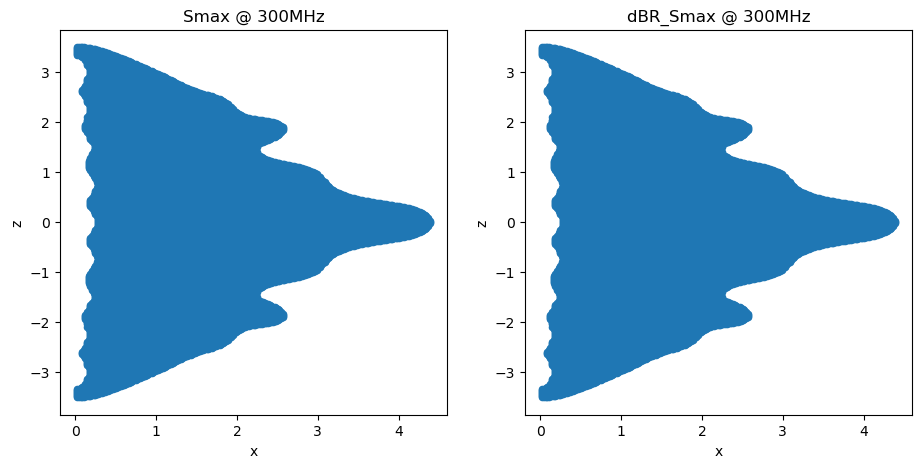

In [32]:
# Check 
fig, ax = plt.subplots(1,2,figsize=(11,5))
Si = 'Smax-1.6m-5-GQ'
Si = 'Smax'
fMHz = 300

Silist = [Si, 'dBR_'+Si]
for i, Si in enumerate(Silist):
    mask = (SallR.fMHz == fMHz) & (SallR.metric == Si) 
    SallR[mask].plot.scatter('x','z',ax=ax[i],title=f'{Si} @ {fMHz}MHz');

## Check whole body SAR values

### Plot SARwbi values

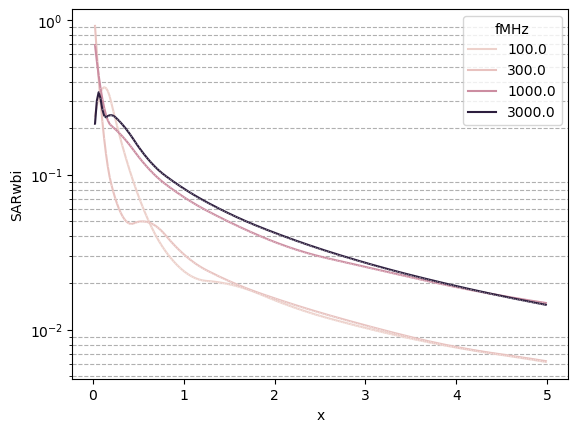

In [33]:
mask = Sall2.z==0
sns.lineplot(data=Sall2[mask],x='x',y='SARwbi',marker='o',
            markersize=0.1,hue='fMHz')
plt.grid(ls='--',which='minor')
plt.yscale("log");

### Single IEC SAR formula check

In [34]:
d = 1  # x distance of body to antenna
body = 'adult'
fMHz = 1000
P = 100      # radiated antenna power
N = 4        # No. of driven elements in antenna
DdBi = 7.4   # peak directivity of the antenna (dBi)
L = omni_length(fMHz)  # length of antenna
Φdeg = 360   # horizontal half-power beamwidth (degrees) of the antenna
Θdeg = 18    # vertical half-power beam width (degrees) of the antenna

SARwb = SAR_IEC_front(d,body,fMHz,P,N,DdBi,L,Φdeg,Θdeg)[0]
print(f'SARwb = {SARwb:0.3f} W/kg')

SARwb = 0.090 W/kg


In [35]:
# Print omni antenna lengths for all frequencies
print('fMHz   L (m)')
for fMHz in FREQS:
    L = omni_length(fMHz)
    print(f'{fMHz:5g}  {L:0.2f}')

fMHz   L (m)
  100  12.75
  300  4.25
 1000  1.27
 3000  0.43


### Multiple IEC SAR formula checks (300,1000,3000 MHz)

In [36]:
# Create dfSAR dataframe
mask = (Sall2.z == 0) & (Sall2.fMHz.isin([300,1000,3000]))
dfSAR = Sall2.loc[mask,['fMHz','x','SARwbi']].dropna().copy()
dfSAR = dfSAR.rename(columns={'SARwbi':'SAR_FEKO'})

# Vectorize the SAR_IEC_front and omni_length functions
SAR_IEC_front_vec = np.vectorize(SAR_IEC_front)
omni_length_vec = np.vectorize(omni_length)

# Calculate IEC SAR
d = dfSAR.x.values
fMHz = dfSAR.fMHz.values
L = omni_length_vec(fMHz)
dfSAR['L'] = L
dfSAR['SAR_IEC'] = SAR_IEC_front_vec(d,body,fMHz,P,N,DdBi,L,Φdeg,Θdeg)[0]

# Calculate ratio of SAR_FEKO / SAR_IEC
dfSAR['ratio'] = (dfSAR.SAR_FEKO / dfSAR.SAR_IEC).round(3)

dfSAR.head()

,fMHz,x,SAR_FEKO,L,SAR_IEC,ratio
399049,300.0,0.025,0.916807,4.25,NaN,NaN
399850,300.0,0.045,0.610781,4.25,NaN,NaN
400651,300.0,0.065,0.421821,4.25,NaN,NaN
401452,300.0,0.085,0.301998,4.25,NaN,NaN
402253,300.0,0.105,0.224138,4.25,NaN,NaN


ratio = $\frac{SAR_{FEKO}}{SAR_{IEC}}$

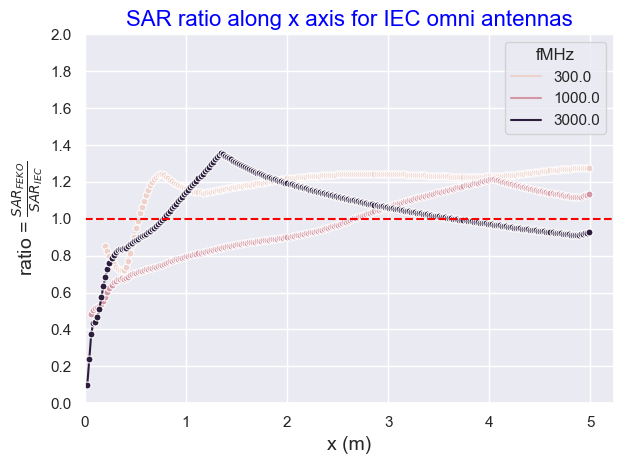

In [37]:
# Plot SAR ratio
title = r'SAR ratio along x axis for IEC omni antennas'
sns.set_theme()
g = sns.lineplot(data=dfSAR,x='x',y='ratio',marker='o',
               hue='fMHz',markersize=5)
plt.ylim(0, None)
plt.xlim(0,None)
plt.axhline(1,color='red',ls='--')
plt.xlabel('x (m)',fontsize=14)
plt.ylabel(r'ratio = $\frac{SAR_{FEKO}}{SAR_{IEC}}$',fontsize=14)
plt.yticks(np.arange(0,2.2,0.2))
plt.title(title,color='blue',fontsize=16)
plt.tight_layout()
plt.savefig(PLOTDIR+f'SAR ratio vs x scatterlot.png',dpi=200)

## Draw plots

### Compliance boundary plots

In [38]:
mask = Sall2.fMHz == 100
Sall2.loc[mask,'SARwbi'].size

378729

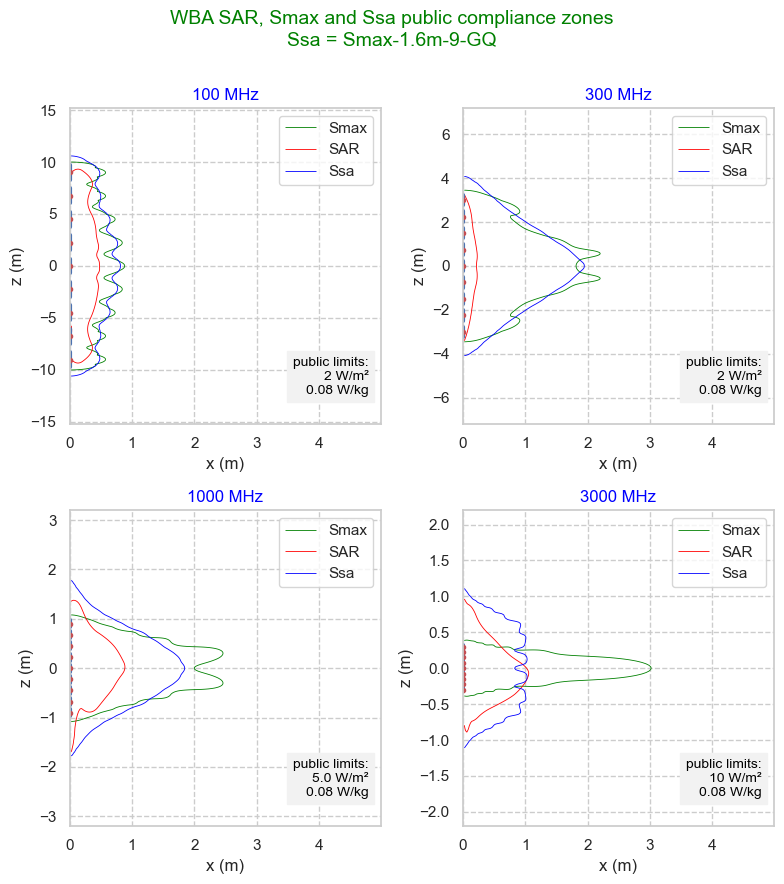

In [39]:
# Plot settings
Ssa = 'Smax-1.6m-9-GQ'
setting = 'public'
rows, cols = 2, 2

# Plot compliance boundaries
sns.set_style("whitegrid")
fig, axes = plt.subplots(rows,cols,figsize=(8,9))
for i, trial in enumerate(TRIALS):
    t = trialdata[trial]
    mask = (Sall2.trial == trial)
    complot(Sall2[mask],t,setting,Ssa=Ssa,axes=axes,axi=i)

# Finish off figure
plot_title = f"WBA SAR, Smax and Ssa {setting} compliance zones\nSsa = {Ssa}\n"
fig.suptitle(plot_title, color='green', fontsize=14)
fig.tight_layout()
fig.savefig(PLOTDIR + f'IEC complot {Ssa}.png',dpi=200)

Text(0.5, 1.0, '3000 MHz   Ssa = Smax-1.6m-9-GQ')

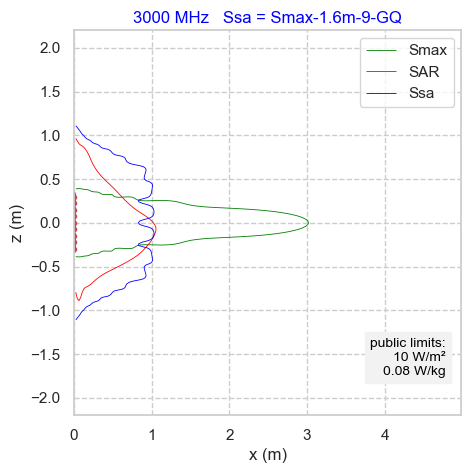

In [40]:
Ssa = 'Smax-1.6m-9-GQ'
trial = 13  # 3000 MHz
t = trialdata[trial]
mask = (Sall2.trial == trial)
complot(Sall2[mask],t,setting,Ssa=Ssa,figsize=(5,5))
plt.title(f'{t.fMHz} MHz   Ssa = {Ssa}')

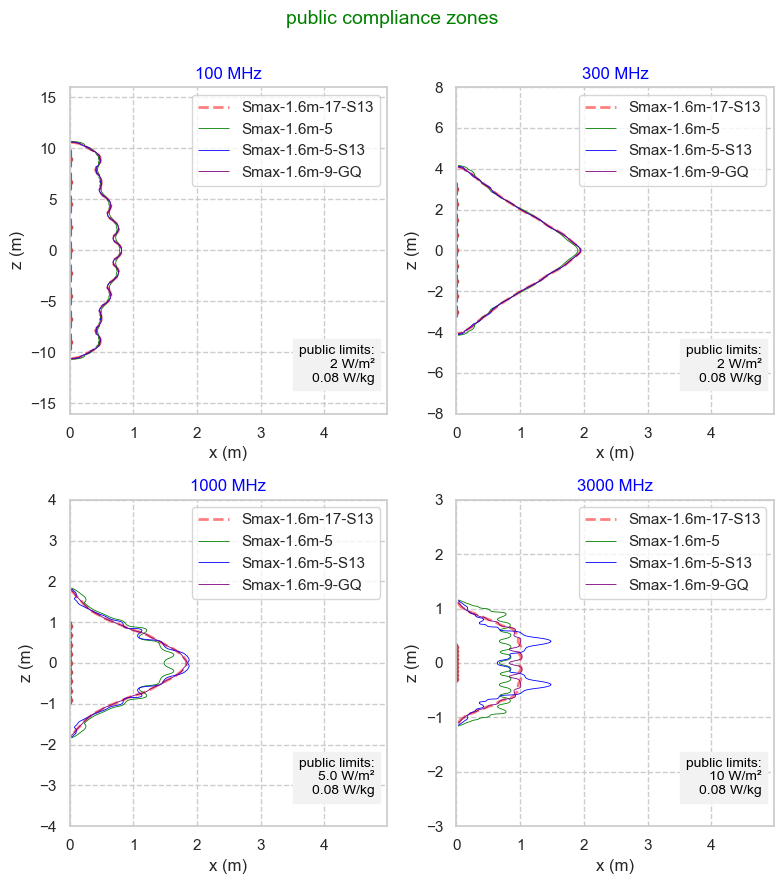

In [41]:
# Plot settings
Scols = ['Smax-1.6m-17-S13','Smax-1.6m-5','Smax-1.6m-5-S13','Smax-1.6m-9-GQ']
setting = 'public'
rows, cols = 2, 2

# Plot compliance boundaries
sns.set_style("whitegrid")
fig, axes = plt.subplots(rows,cols,figsize=(8,9))
for i, trial in enumerate(TRIALS):
    t = trialdata[trial]
    mask = (Sall.trial == trial)
    complot2(Sall[mask],t,setting,Scols=Scols,axes=axes,axi=i)

# Finish off figure
plot_title = f"{setting} compliance zones\n"
fig.suptitle(plot_title, color='green', fontsize=14)
fig.tight_layout()
fig.savefig(PLOTDIR + f'PD620 complot compare Ssa.png',dpi=200)


In [60]:
Sall.head()

,trial,fMHz,x,y,z,wtx,SE,SH,Smax,SARwbi,...,dBR_Smax-1.6m-5-GQ,R_Smax-1.6m-9-GQ,dBR_Smax-1.6m-9-GQ,dBerr_Smax,dBerr_Smax-1.6m-17-S13,dBerr_Smax-1.6m-5,dBerr_Smax-1.6m-5-S13,dBerr_Smax-1.6m-9-S13,dBerr_Smax-1.6m-5-GQ,dBerr_Smax-1.6m-9-GQ
0,10,100.0,0.025,0.0,-16.00,2,0.000097,6.644444e-08,0.000097,0.000004,...,-0.017934,0.995880,-0.017932,1.689958,0.0,0.719627,0.383476,0.131528,1.912723,1.912725
1,10,100.0,0.025,0.0,-15.98,2,0.000098,6.728269e-08,0.000098,0.000004,...,0.076795,1.017840,0.076796,1.686215,0.0,0.720145,0.383165,0.131416,1.910754,1.910754
2,10,100.0,0.025,0.0,-15.96,2,0.000099,6.813409e-08,0.000099,0.000004,...,0.170598,1.040063,0.170597,1.682448,0.0,0.720667,0.382851,0.131304,1.908729,1.908728
3,10,100.0,0.025,0.0,-15.94,2,0.000100,6.899887e-08,0.000100,0.000004,...,0.263478,1.062546,0.263476,1.678658,0.0,0.721194,0.382536,0.131192,1.906652,1.906650
4,10,100.0,0.025,0.0,-15.92,2,0.000102,6.987729e-08,0.000102,0.000004,...,0.355441,1.085285,0.355437,1.674843,0.0,0.721725,0.382219,0.131079,1.904526,1.904523


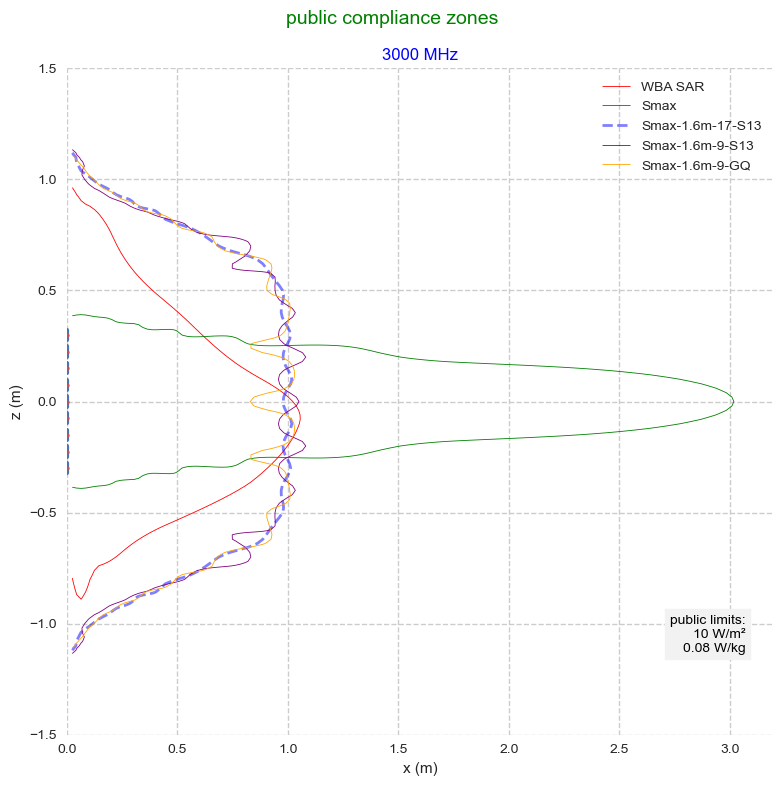

In [61]:
# Plot settings
trial = 13
Scols = ['SARwbi','Smax','Smax-1.6m-17-S13','Smax-1.6m-9-S13','Smax-1.6m-9-GQ']
setting = 'public'

# Plot compliance boundaries
sns.set_style("whitegrid")
t = trialdata[trial]
mask = (Sall.trial == trial)
complot2(Sall[mask],t,setting,Scols=Scols,figsize=(8,8))   

# Finish off figure
plt.xlim(0,3.2)
plt.ylim(-1.5,1.5)
plot_title = f"{setting} compliance zones"
plt.suptitle(plot_title, color='green', fontsize=14)
plt.tight_layout()
plt.savefig(PLOTDIR + f'IEC complot compare Ssa at {round(t.fMHz)}MHz.png',dpi=200)


### Check Ssa convergence at 3000 MHz

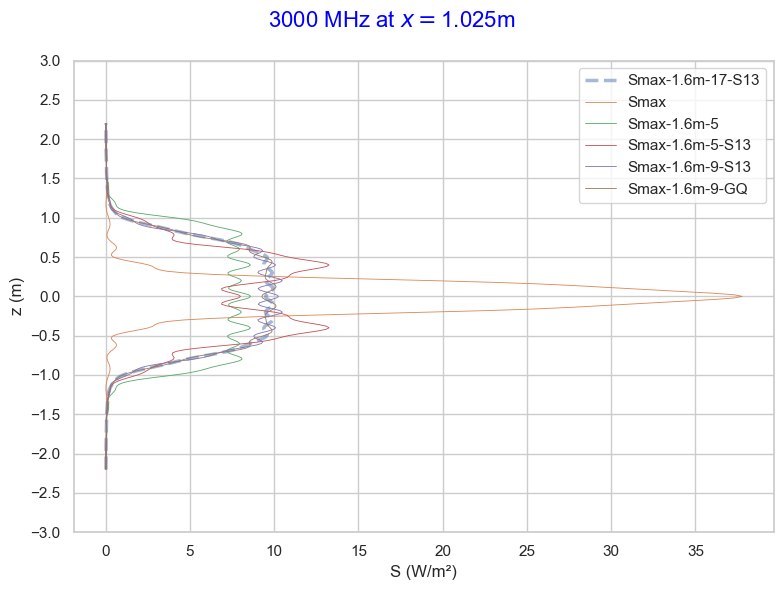

In [43]:
# Compare Ssa levels at x=1.05m at 3000 MHz
fMHz = 3000
xp = 1.025
Ssa = ['Smax-1.6m-17-S13','Smax','Smax-1.6m-5','Smax-1.6m-5-S13',
       'Smax-1.6m-9-S13','Smax-1.6m-9-GQ']
# Ssa = ['Smax','Smax-1.6m-17-S13','Smax-1.6m-5-S13','Smax-1.6m-5-GQ']

mask = (Sall2.fMHz==fMHz) & (Sall2.x == xp)
SGC = Sall2[mask]
zsa = SGC.z.values[8:-8]

fig,ax = plt.subplots(figsize=(8,6))
for Si in Ssa:
    if Si=='Smax-1.6m-17-S13':
        lw,alpha,ls = 2.5,0.5,'--'
    else:
        lw,alpha,ls = 0.6,1.0,'-'
    SGC.plot(Si,'z',ax=ax,label=Si,lw=lw,ls=ls,alpha=alpha)
plt.yticks(np.arange(-3,3.5,0.5))
ax.set_xlabel('S (W/m²)');
ax.set_ylabel('z (m)');
fig.suptitle(f'{fMHz} MHz at $x=${xp}m',fontsize=16,color='blue')
fig.tight_layout()
plt.savefig(PLOTDIR + f'PD620 compare Ssa x={xp} {fMHz}MHz.png',dpi=200)

### Smax vertical plots

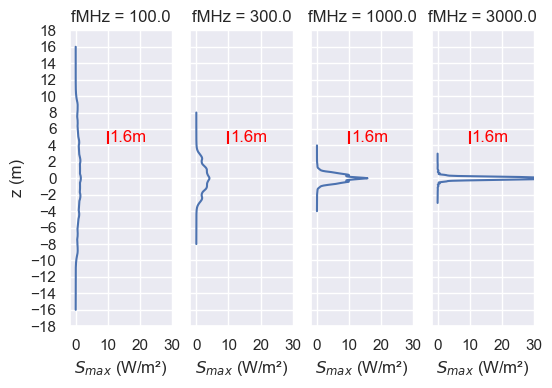

In [44]:
mask = (S.x == 1.025)
sns.set_style("darkgrid")
g = sns.relplot(S[mask],x="Smax",y="z",col="fMHz",
                kind="line",height=4, aspect=0.35,sort=False)
for ax in g.axes.flatten():
    ax.vlines(x=10,ymin=5-0.8,ymax=5+0.8,color='red')
    ax.text(10.5,5,'1.6m',color='red',va='center',ha='left')

g.set(xlim=(None,30),
      xticks=(range(0,40,10)),yticks=range(-18,20,2),
      ylabel="z (m)",xlabel="$S_{max}$ (W/m²)")
plt.savefig(PLOTDIR+'Smax unifomity over z.png',dpi=200)

### dBR sampling points

Text(0.5, 0.98, 'R assessment points for dBR_Smax and antenna power 50 to 200 W')

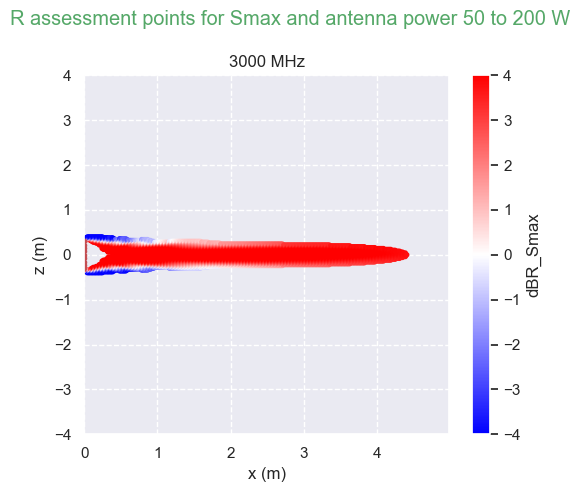

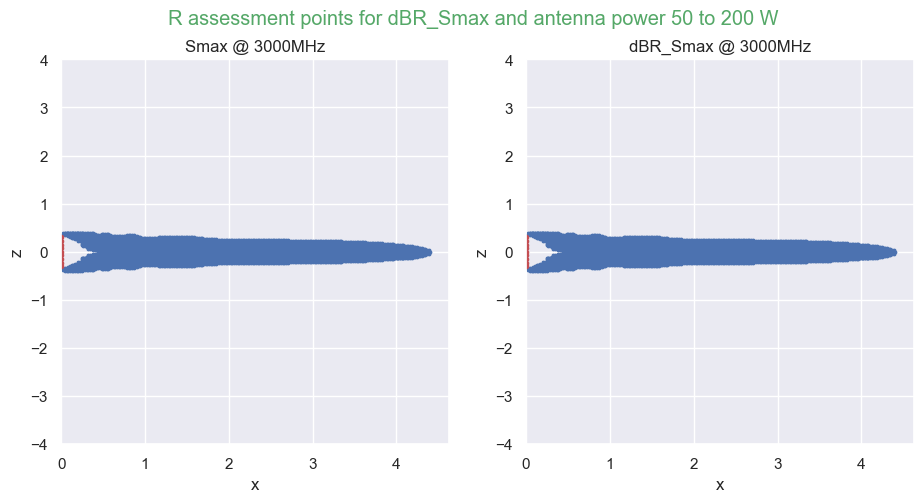

In [45]:
Si = 'Smax'
fMHz = 3000

fig1, ax1 = plt.subplots(figsize=(5.5,5))
Rpoints(ax1,Sall2,Si,fMHz,POWER_LOW,POWER_HIGH,True,8)
ax1.set_ylim(-4,4)
fig1.suptitle(f"R assessment points for {Si} and antenna power {POWER_LOW*POWER:g} to {POWER_HIGH*POWER} W",
             color='g')
fig1.tight_layout()
# plt.savefig(PLOTDIR+f'dBR points for {Si} {fMHz}MHz.png',dpi=200)

# Check against values in SallR
fig2, ax2 = plt.subplots(1,2,figsize=(11,5))
Silist = [Si, 'dBR_'+Si]
for i, Si in enumerate(Silist):
    mask = (SallR.fMHz == fMHz) & (SallR.metric == Si) 
    SallR[mask].plot.scatter('x','z',s=3,ax=ax2[i],title=f'{Si} @ {fMHz}MHz')
    ax2[i].set_ylim(-4,4)
    ax2[i].set_xlim(0,None)
    omni(fMHz, ax2[i])
fig2.suptitle(f"R assessment points for {Si} and antenna power {POWER_LOW*POWER:g} to {POWER_HIGH*POWER} W",
             color='g')

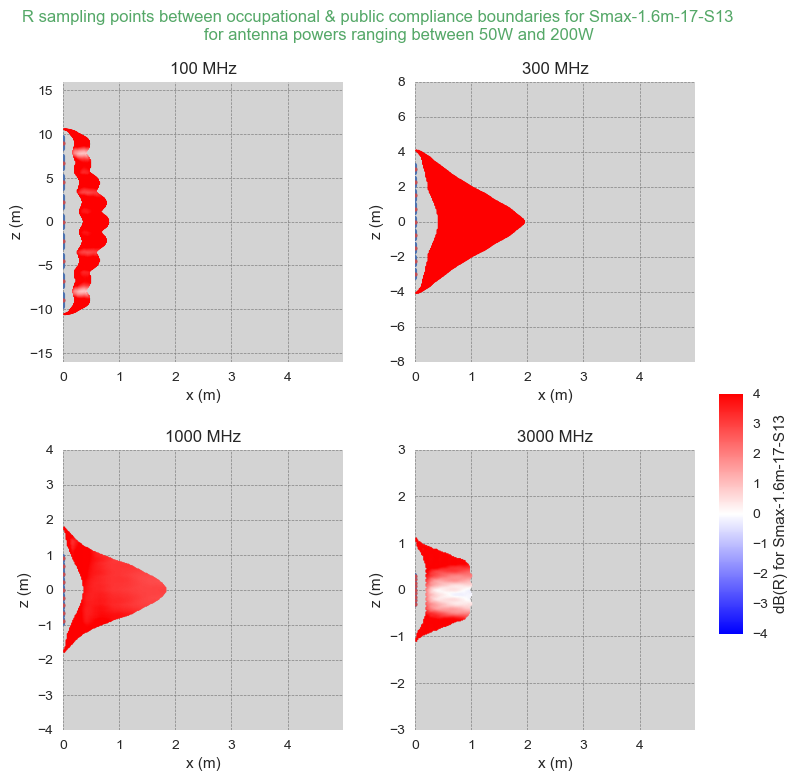

In [53]:
Si = 'Smax'
Si = 'Smax-1.6m-17-S13'

# Generate axes
fig = plt.figure(figsize=(8,8))
axes = []
width = 0.35
height = 0.35
for bottom in [0.54,0.08]:
    for left in [0.08,0.52]:
        axes.append(fig.add_axes([left,bottom,width,height]))
axcb = fig.add_axes([0.9,0.2,0.03,0.3])

# Generate plots
for i, fMHz in enumerate(freqs):
    # Rpoints(axes[i],Sall,Si,fMHz,POWER_LOW,POWER_HIGH)
    Rpoints(axes[i],Sall,Si,fMHz,1,1)
    axes[i].set_facecolor('lightgrey')
    axes[i].grid(color='grey',lw=0.5)
    
# colorbar
cmap = mpl.cm.bwr
norm = mpl.colors.Normalize(vmin=-4, vmax=4)
cb1 = mpl.colorbar.ColorbarBase(axcb, cmap=cmap,
                                norm=norm,label=f'dB(R) for {Si}',
                                orientation='vertical')
# Set title
title = f'R sampling points between occupational & public compliance boundaries for {Si} \
        \nfor antenna powers ranging between {POWER*POWER_LOW:g}W and {POWER*POWER_HIGH:g}W'
fig.suptitle(title,color='g',fontsize=12)

fig.tight_layout()
plt.savefig(PLOTDIR+f'dBR points for {Si}.png',dpi=200)

### R histograms

#### Single case (weighted) for pts b/w compliance boundaries

3000 MHz: S limit = 10 W/m², SAR limit = 0.08 W/kg
5333


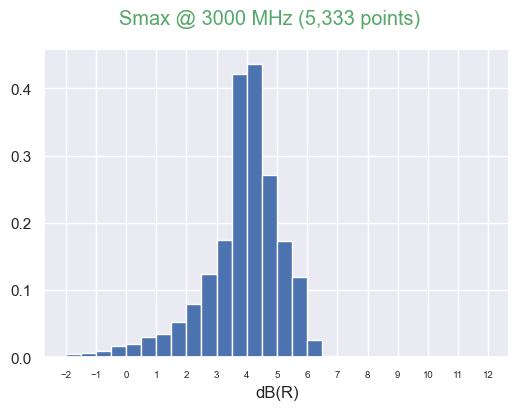

In [47]:
# Set parameters
fMHz = 3000
Si = "Smax-1.6m-17-S13"
Si = "Smax"
Ri = "dBR_" + Si

# Calculate limit values
limSpub = Slimit(fMHz, setting='pub', standard='RPS S-1 WB')
limSocc = Slimit(fMHz, setting='occ', standard='RPS S-1 WB')
print(f'{fMHz} MHz: S limit = {limSpub} W/m², SAR limit = {limSARpub} W/kg')

# set mask for trial
mask = (Sall2.fMHz == fMHz) & \
       (Sall2[Si] >= limSpub*POWER_LOW) & \
       (Sall2[Si] <= limSocc*POWER_HIGH)
print(sum(mask))

# Create figure
fig, ax = plt.subplots(1,1,figsize=(6,4))
bins = np.arange(-2,12.5,0.5)

# Plot histogram 1
ax.hist(Sall2.loc[mask,Ri], bins=bins, density=True,
        weights=Sall2.loc[mask,'wtx'])
ax.set_xticks(ticks=bins)
plt.xticks(range(-2,13,1),fontsize=7)
ax.set_xlabel('dB(R)')
fig.suptitle(f'{Si} @ {fMHz} MHz ({sum(mask):,g} points)',color='g');

#### dB(R) histogram function (x-weighted)

In [48]:
def dBR_hist(df,fMHz_list,Si_list,bins,figsize,xticks=None):
    '''Generate histogram plots of dB(R) for the values
       specified in fMHz_list & Si_list, weighted for x
       INPUTS:
         df = dataframe of data points between compliance boundaries
              in long format (i.e., SallR)
         fMHz_list = list of frequencies to be plotted
         Si_list = list of spatial average options
         bins = histogram bins
         figsize = tuple for figures size (width, height) in inches
         xticks = xtick lables for the plots
         '''
    # Create the figure
    nrows = len(Si_list)
    ncols = len(fMHz_list)
    fig, axes = plt.subplots(nrows,ncols,figsize=figsize,
                             sharex=True,sharey=True)

    # Plot the histograms
    for i, fMHz in enumerate(fMHz_list):
        for j, Si in enumerate(Si_list):
            ax = axes[j,i]
            dBRSi = 'dBR_' + Si
            mask = (df.fMHz == fMHz) & (df.metric == dBRSi)
            data = df.loc[mask,'value'].values
            wtx = df.loc[mask,'wtx'].values
            data_wtx = np.repeat(data, wtx)  # create x-weighted data
            ax.hist(data_wtx,bins=bins,density=True)
            CI95 = np.percentile(data_wtx,[2.5,97.5]).round(1)
            mean_wtx = data_wtx.mean().round(1)
            ax.set_xlim(bins.min(),bins.max())
            ax.axvline(0,color='red',ls='--')
            title = f'{fMHz} (MHz)' if j == 0 else ''
            ax.set_title(title, fontsize=12,color='green')
            CItext = f'95% CI:\n{CI95[0]} to {CI95[1]} dB\nµ = {mean_wtx} dB\n{sum(mask):,g} points'
            ax.text(0.98, 0.96, CItext,fontsize=8,color='navy',
                    horizontalalignment='right',verticalalignment='top',
                    transform=ax.transAxes)
            if xticks != None: ax.set_xticks(xticks)
            if i%nrows == 0: ax.set_ylabel("Probability density")
            if j == nrows-1: ax.set_xlabel("dB(R)")
            if i == ncols-1:
                ax.text(1.05, 0.5, Si, horizontalalignment='center',color='g',
                        rotation=-90,verticalalignment='center', fontsize=12,
                        transform=ax.transAxes)
    fig.suptitle('dB(R) histograms for points between compliance boundaries\nweighted by x\n',
                 color='black', fontsize=14)
    fig.tight_layout()                
    plt.savefig(PLOTDIR+f'dBR histograms for {fMHz_list}.png',dpi=200)

#### 100, 300, 1000, 3000 MHz

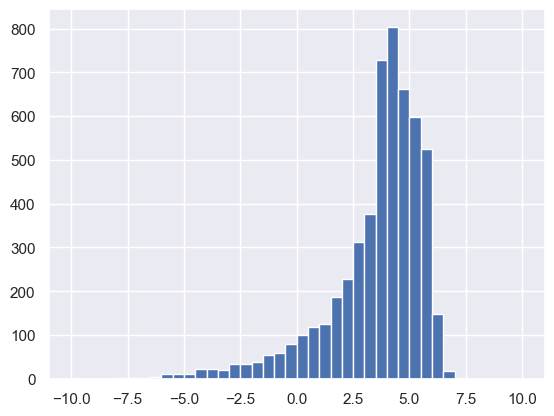

In [49]:
mask = (SallR.fMHz==3000.) & (SallR.metric=='dBR_Smax')
SallR.loc[mask,'value'].hist(bins = np.arange(-10,10.5,0.5));


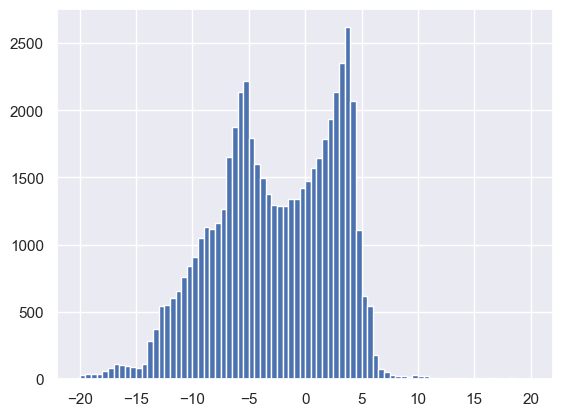

In [50]:
mask = (Sall2.fMHz==3000.)
Sall2.loc[mask,'dBR_Smax'].hist(bins = np.arange(-20,20.5,0.5));

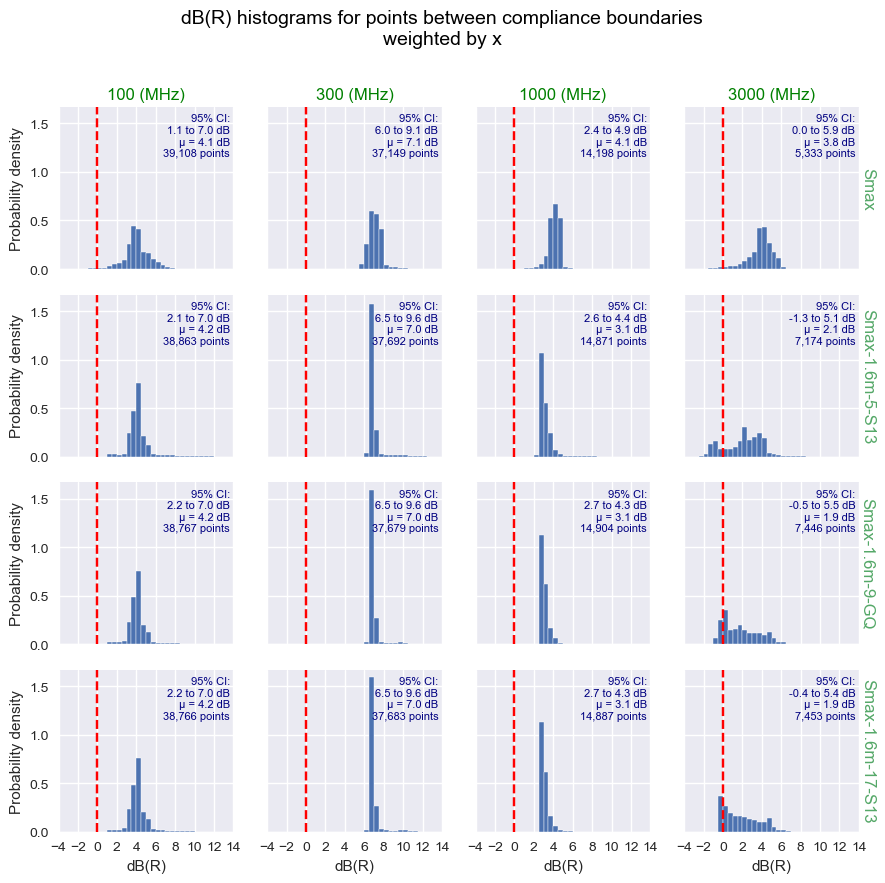

In [52]:
plt.style.use('seaborn-v0_8')
fMHz_list = [100, 300, 1000, 3000]
Si_list = ['Smax','Smax-1.6m-5-S13',
           'Smax-1.6m-9-GQ','Smax-1.6m-17-S13']
df = SallR
bins = np.arange(-4,14.5,0.5)
xticks = range(-4,16,2)
dBR_hist(df,fMHz_list,Si_list,bins,figsize=(9,9),xticks=xticks)

#### Check values

In [52]:
def CI95(arr):
    ci95 = np.percentile(arr, [2.5,97.5])
    return f'{ci95[0]:0.1f} to {ci95[1]:0.1f}'

Si = 'dBR_Smax-1.6m-17-S13'
mask = (SallR.metric == Si)

table_list = []
for fMHz, g in SallR[mask].groupby('fMHz'):
    data = np.repeat(g.value.values, g.wtx.values)
    m = data.mean().round(1)
    ci = CI95(data)
    table_list.append([int(fMHz), m, ci])

table = pd.DataFrame(table_list, columns=['Freq (MHz)','Mean (dB)','95% CI (dB)'])
table.set_index('Freq (MHz)')
print(f'dB(R) stats for {Si}')
table

dB(R) stats for dBR_Smax-1.6m-17-S13


,Freq (MHz),Mean (dB),95% CI (dB)
0,100,4.2,2.2 to 7.0
1,300,7.0,6.5 to 9.6
2,1000,3.1,2.7 to 4.3
3,3000,1.9,-0.4 to 5.4


In [53]:
# Check values
print('*** C95 CI for dB R values ***')
for Si in Si_list:
    dBRSi = 'dBR_' + Si
    for fMHz in fMHz_list:
        mask = (SallR.metric==dBRSi) & (SallR.fMHz==fMHz)
        data = SallR.loc[mask,'value'].values
        wtx = SallR.loc[mask,'wtx'].values
        data_wtx = np.repeat(data, wtx)
        C95 = np.percentile(data_wtx,[2.5,97.5]).round(1)
        print(f'{Si:17} {fMHz:5} MHz [{C95[0]:3.1f} to {C95[1]:4.1f}]  {len(data):5,g} points')

*** C95 CI for dB R values ***
Smax                100 MHz [1.1 to  7.0]  39,108 points
Smax                300 MHz [6.0 to  9.1]  37,149 points
Smax               1000 MHz [2.4 to  4.9]  14,198 points
Smax               3000 MHz [0.0 to  5.9]  5,333 points
Smax-1.6m-5         100 MHz [2.4 to  7.0]  39,011 points
Smax-1.6m-5         300 MHz [6.5 to  9.7]  37,754 points
Smax-1.6m-5        1000 MHz [2.0 to  5.6]  14,890 points
Smax-1.6m-5        3000 MHz [-1.4 to  9.9]  7,617 points
Smax-1.6m-5-S13     100 MHz [2.1 to  7.0]  38,863 points
Smax-1.6m-5-S13     300 MHz [6.5 to  9.6]  37,692 points
Smax-1.6m-5-S13    1000 MHz [2.6 to  4.4]  14,871 points
Smax-1.6m-5-S13    3000 MHz [-1.3 to  5.1]  7,174 points
Smax-1.6m-9-S13     100 MHz [2.2 to  7.0]  38,792 points
Smax-1.6m-9-S13     300 MHz [6.5 to  9.6]  37,673 points
Smax-1.6m-9-S13    1000 MHz [2.7 to  4.3]  14,914 points
Smax-1.6m-9-S13    3000 MHz [-0.5 to  5.6]  7,374 points
Smax-1.6m-9-GQ      100 MHz [2.2 to  7.0]  38,767 points
S

#### Table of descriptive stats for x-weighted data

In [209]:
def showRstats(df, Si_list, fMHz_list, dB=True):
    table = []
    for fMHz in fMHz_list:
        for Si in Si_list: 
            Rcol = f'R_{Si}'
            mask = (df.metric==Rcol) & (df.fMHz==fMHz)
            data = df.loc[mask,'value'].values
            wtx = df.loc[mask,'wtx'].values
            data_wtx = np.repeat(data, wtx)
            dataname = ''
            if dB:
                data_wtx = 10. * np.log10(data_wtx)
                dataname = 'dB(R) data'
            count = len(data)
            ci = np.percentile(data_wtx,[2.5,50,97.5]).round(1)
            mean = data_wtx.mean().round(1)
            std = data_wtx.std().round(2)
            minval = data_wtx.min().round(1)
            maxval = data_wtx.max().round(1)
            table.append([fMHz,Si,count,mean,std,minval,ci[0],ci[1],ci[2],maxval])
    table = pd.DataFrame(table,columns=('fMHz','Si','count','mean','std','min','2.5%','50%','97.5%','max'))
    table = table.set_index(['fMHz','Si'])
    table.columns.name = dataname
    
    return table

Si_list = ['Smax','Smax-1.6m-5','Smax-1.6m-5-S13','Smax-1.6m-9-S13','Smax-1.6m-9-GQ','Smax-1.6m-17-S13']
Rstats = showRstats(SallR, Si_list, FREQS, dB=True)
Rstats

dB(R) data             count  mean   std  min  2.5%  50%  97.5%   max
fMHz Si                                                              
100  Smax              39108   4.1  1.41 -3.0   1.1  4.0    7.0  15.9
     Smax-1.6m-5       39011   4.2  1.14  1.5   2.4  4.1    7.0  25.2
     Smax-1.6m-5-S13   38863   4.2  1.10  1.1   2.1  4.1    7.0  23.4
     Smax-1.6m-9-S13   38792   4.2  1.10  0.9   2.2  4.1    7.0  22.5
     Smax-1.6m-9-GQ    38767   4.2  1.10  0.9   2.2  4.1    7.0  22.7
     Smax-1.6m-17-S13  38766   4.2  1.10  0.9   2.2  4.1    7.0  23.6
300  Smax              37149   7.1  0.75 -1.5   6.0  7.1    9.1  15.4
     Smax-1.6m-5       37754   7.0  0.72  6.1   6.5  6.8    9.7  18.6
     Smax-1.6m-5-S13   37692   7.0  0.65  6.2   6.5  6.9    9.6  17.6
     Smax-1.6m-9-S13   37673   7.0  0.66  6.2   6.5  6.9    9.6  16.3
     Smax-1.6m-9-GQ    37679   7.0  0.66  5.9   6.5  6.9    9.6  16.8
     Smax-1.6m-17-S13  37683   7.0  0.66  6.2   6.5  6.9    9.6  17.1
1000 Smax              14198   4.1  0.67 -9.0   2.4  4.2    4.9   9.0
     Smax-1.6m-5       14890   3.0  1.03  1.9   2.0  2.7    5.6  17.1
     Smax-1.6m-5-S13   14871   3.1  0.56  1.5   2.6  2.9    4.4  18.0
     Smax-1.6m-9-S13   14914   3.1  0.50  2.7   2.7  3.0    4.3  16.4
     Smax-1.6m-9-GQ    14904   3.1  0.49  2.2   2.7  3.0    4.3  16.1
     Smax-1.6m-17-S13  14887   3.1  0.49  2.0   2.7  3.0    4.3  14.9
3000 Smax               5333   3.8  1.42 -7.8   0.0  4.0    5.9   6.7
     Smax-1.6m-5        7617   2.8  3.40 -1.8  -1.4  2.0    9.9  22.3
     Smax-1.6m-5-S13    7174   2.1  1.87 -2.1  -1.3  2.3    5.1  20.8
     Smax-1.6m-9-S13    7374   1.9  1.82 -0.7  -0.5  1.6    5.6  17.8
     Smax-1.6m-9-GQ     7446   1.9  1.83 -0.8  -0.5  1.6    5.5  16.3
     Smax-1.6m-17-S13   7453   1.9  1.81 -0.4  -0.4  1.5    5.4  16.8

In [220]:
Rstats2['95% CI (dB)'] = [f'{a} to {b}' for a, b in zip(Rstats['2.5%'].values, Rstats['97.5%'].values)]
Rstats2.iloc[:,-1].to_frame()

95% CI (dB)
fMHz Si                           
100  Smax               1.1 to 7.0
     Smax-1.6m-5        2.4 to 7.0
     Smax-1.6m-5-S13    2.1 to 7.0
     Smax-1.6m-9-S13    2.2 to 7.0
     Smax-1.6m-9-GQ     2.2 to 7.0
     Smax-1.6m-17-S13   2.2 to 7.0
300  Smax               6.0 to 9.1
     Smax-1.6m-5        6.5 to 9.7
     Smax-1.6m-5-S13    6.5 to 9.6
     Smax-1.6m-9-S13    6.5 to 9.6
     Smax-1.6m-9-GQ     6.5 to 9.6
     Smax-1.6m-17-S13   6.5 to 9.6
1000 Smax               2.4 to 4.9
     Smax-1.6m-5        2.0 to 5.6
     Smax-1.6m-5-S13    2.6 to 4.4
     Smax-1.6m-9-S13    2.7 to 4.3
     Smax-1.6m-9-GQ     2.7 to 4.3
     Smax-1.6m-17-S13   2.7 to 4.3
3000 Smax               0.0 to 5.9
     Smax-1.6m-5       -1.4 to 9.9
     Smax-1.6m-5-S13   -1.3 to 5.1
     Smax-1.6m-9-S13   -0.5 to 5.6
     Smax-1.6m-9-GQ    -0.5 to 5.5
     Smax-1.6m-17-S13  -0.4 to 5.4

### dB(R) vs x scatter plots

#### All points in Sall2

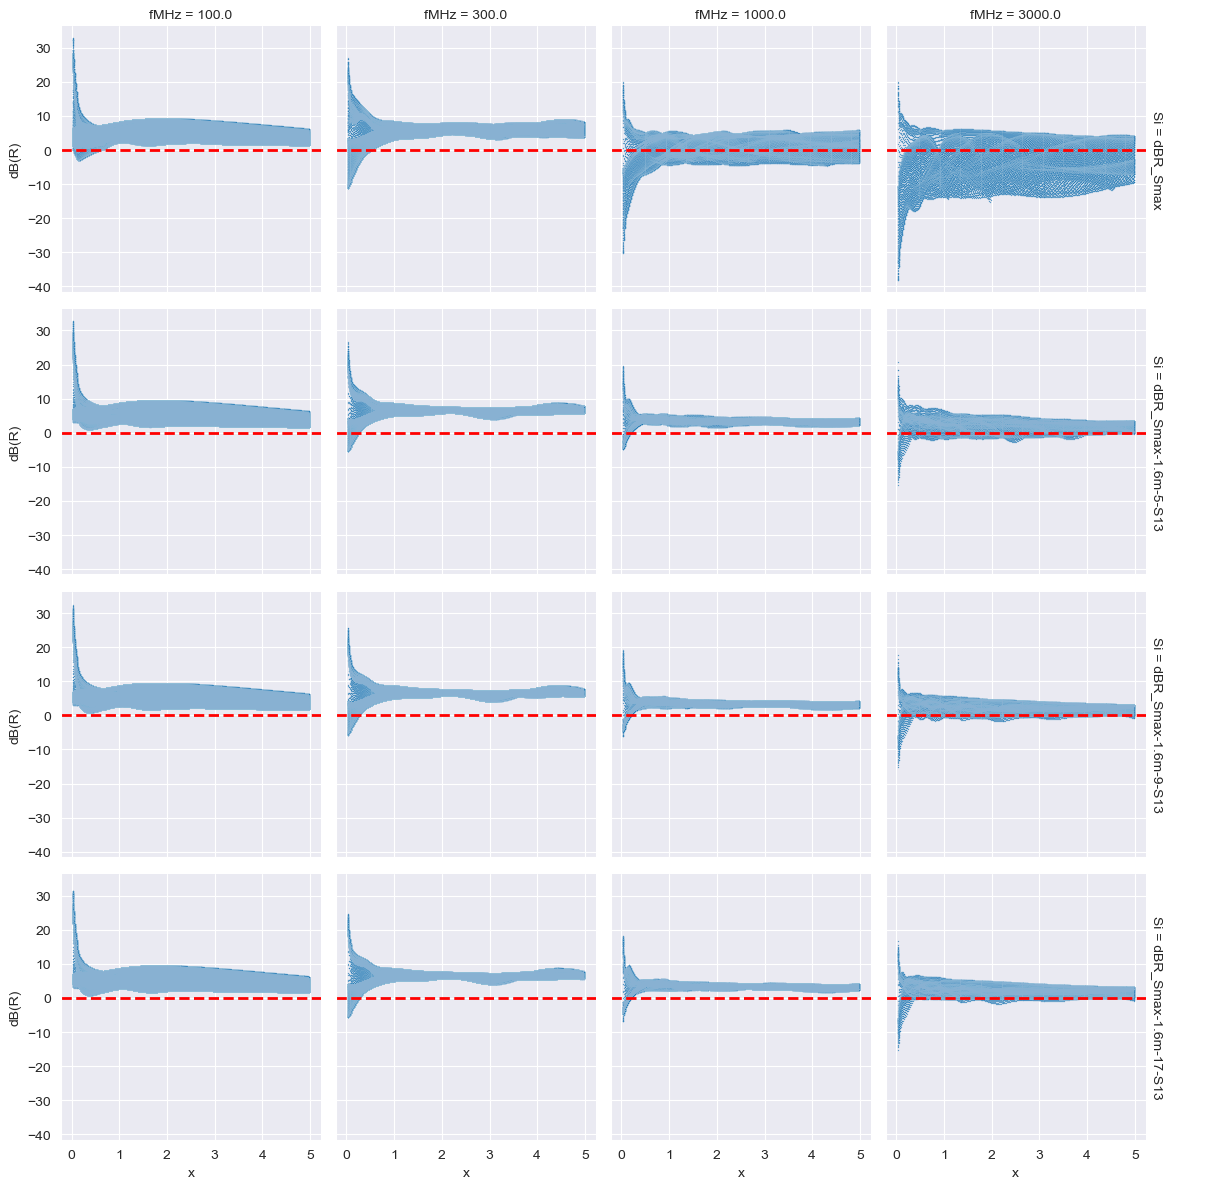

In [55]:
cols = ['x','z','fMHz','dBR_Smax','dBR_Smax-1.6m-5-S13','dBR_Smax-1.6m-9-S13','dBR_Smax-1.6m-17-S13']
df = Sall2[cols].melt(id_vars=cols[:3],value_vars=cols[3:],var_name='Si',value_name='dB(R)')
g = sns.FacetGrid(df, col="fMHz",row="Si",margin_titles=True)
g.map(sns.scatterplot, "x", "dB(R)",alpha=.7,s=1)
g.refline(y=0,color="red",lw=2)
g.add_legend();

#### Points lying b/w compliance boundaries (SallR)

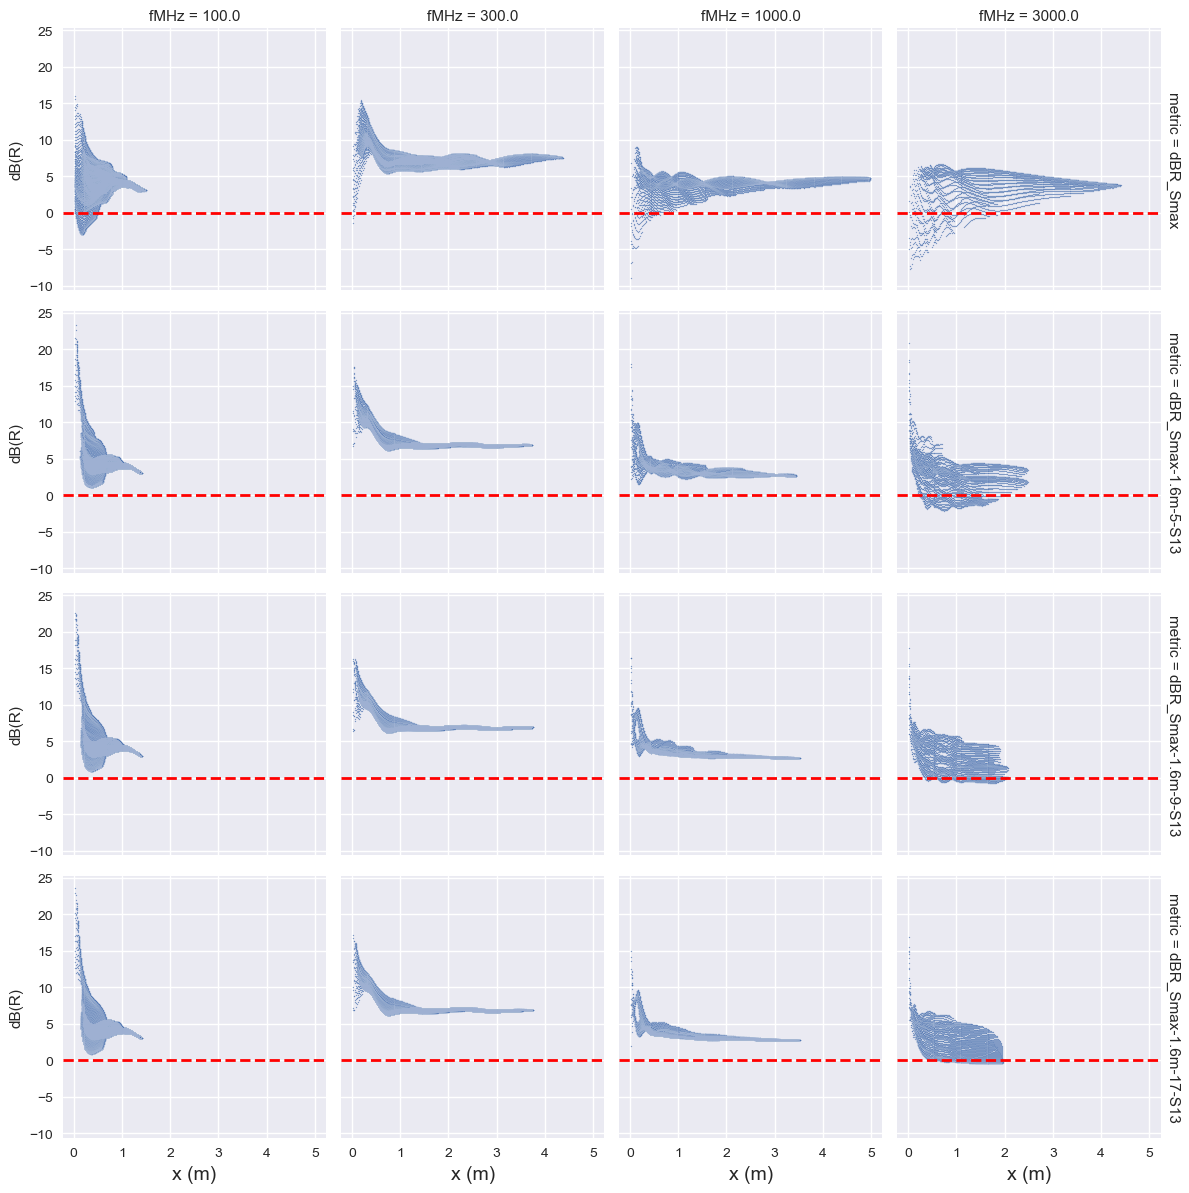

In [119]:
cols = ['dBR_Smax','dBR_Smax-1.6m-5-S13','dBR_Smax-1.6m-9-S13','dBR_Smax-1.6m-17-S13']
mask = SallR.metric.isin(cols)
g = sns.FacetGrid(SallR[mask], col="fMHz",row="metric",
                  margin_titles=True)
g.map(sns.scatterplot,"x","value",alpha=.7,s=1)
g.refline(y=0,color="red",lw=2)
g.set_xlabels('x (m)', fontsize=14)
g.set_ylabels('dB(R)')
plt.savefig(PLOTDIR+f'dBR vs x scatterlots.png',dpi=200)

### Spatial assessment uncertainty
The `Smax-1.6m-17-S13` spatial averaging scheme is taken as the benchmark for a 'near-perfect' spatial average

$err = \frac{S_{sa}}{Smax-1.6m-17-S13}$

#### Histogram function for spatial avg error, x-weighted

In [58]:
def dBerr_hist(df,fMHz_list,Si_list,bins,figsize,xticks=None):
    '''Generate x-weighted histogram plots of dB(err) for the values
       specified in fMHz_list & Si_list
       INPUTS:
         df = dataframe of data points between compliance boundaries
              in long format (i.e., SallR)
         fMHz_list = list of frequencies to be plotted
         Si_list = list of Ssa spatial averaging options
         bins = histogram bins
         figsize = tuple for figures size (width, height) in inches
         xticks = xtick lables for the plots
         '''
    # Create the figure
    nrows = len(Si_list)
    ncols = len(fMHz_list)
    fig, axes = plt.subplots(nrows,ncols,figsize=figsize,
                             sharex=True,sharey=True)

    # Plot the histograms
    for i, fMHz in enumerate(fMHz_list):
        for j, Si in enumerate(Si_list):
            # mask = cbmask(df, Si, fMHz, lowp, highp)
            ax = axes[j,i]
            dBerrcol = 'dBerr_' + Si
            mask = (df.fMHz == fMHz) & (df.metric == dBerrcol)
            data = df.loc[mask,'value'].values
            wtx = df.loc[mask,'wtx'].values
            data_wtx = np.repeat(data, wtx)
            ax.hist(data_wtx,bins=bins,density=True)
            CI95 = np.percentile(data_wtx,[2.5,97.5]).round(1)
            µ = data_wtx.mean()
            ax.set_xlim(bins.min(),bins.max())
            ax.axvline(0,color='red',ls='--')
            if j == 0:
                title = f'{fMHz} (MHz)'
                ax.set_title(title, fontsize=12,color='green')
            CItext = f'95% CI:\n{CI95[0]} to {CI95[1]} dB\nµ = {µ:0.2f} dB\n{sum(mask):,g} points'
            ax.text(0.05, 0.96, CItext,fontsize=8,color='navy',
                    horizontalalignment='left',verticalalignment='top',
                    transform=ax.transAxes)
            if isinstance(xticks, Iterable): ax.set_xticks(xticks)
            if i%nrows == 0: ax.set_ylabel("Probability density")
            if j == nrows-1: ax.set_xlabel("dB(err)")
            if i == ncols-1:
                ax.text(1.05, 0.5, Si, horizontalalignment='center',color='g',
                        rotation=-90,verticalalignment='center', fontsize=12,
                        transform=ax.transAxes)
    fig.suptitle('dB(err) histograms for points between compliance boundaries\nweighted by x\n',
                 color='black', fontsize=14)
    fig.tight_layout()                
    plt.savefig(PLOTDIR+f'dBerr histograms for {fMHz_list}.png',dpi=200)

#### 100, 300, 1000, 3000 MHz

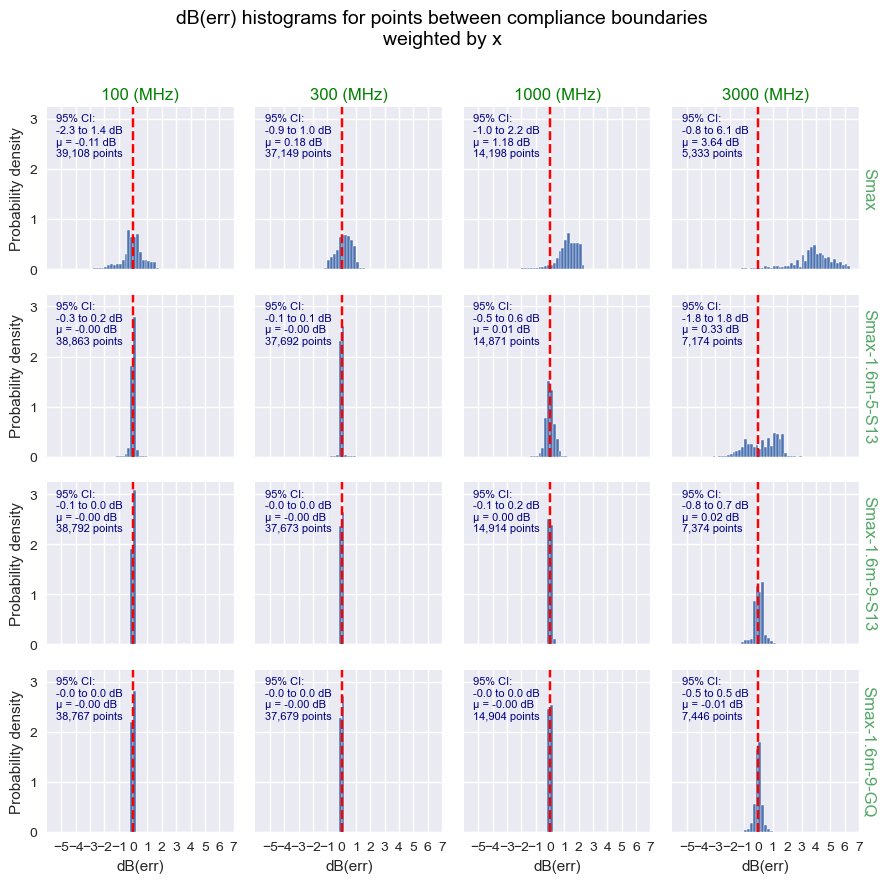

In [59]:
Si_list = ['Smax','Smax-1.6m-5-S13','Smax-1.6m-9-S13','Smax-1.6m-9-GQ']
df = SallR
bins = np.arange(-6,7.2,0.2)
xticks = np.arange(-5,8,1)
dBerr_hist(SallR,FREQS,Si_list,bins,figsize=(9,9),xticks=xticks)

#### dB(err) stats

##### Sall2

In [59]:
# First look at stats for Sall2
cols = ['fMHz'] + [col for col in Sall2.columns if 'dBerr' in col]
df = Sall2[cols]\
  .groupby('fMHz')\
  .describe()\
  .drop(columns=['25%','50%','75%'],level=1)\
  .T.style\
  .format('{:0.2f}')\
  .format_index(formatter='{:,g}', axis=1)
df

##### SallR

In [60]:
# Next look at stats of SallR
dBerr_list = [s for s in SallR.metric if 'dBerr' in s]
mask = SallR.metric.isin(dBerr_list)
SallR.loc[mask,['fMHz','metric','value']]\
  .groupby(['fMHz','metric'])\
  .describe()\
  .drop(columns=['25%','50%','75%'],level=1)\
  .unstack(sort=False)\
  .T\
  .swaplevel(2,1)\
  .sort_index(axis=0,level=1)\
  .style\
  .format('{:0.2f}')\
  .format_index(formatter='{:,g}', axis=1)

##### SallR x-weighted

In [61]:
def showErrStats(df, Ssa_list, fMHz_list):
    table = []
    for fMHz in fMHz_list:
        for Ssa in Ssa_list: 
            Rcol = f'dBerr_{Ssa}'
            mask = (df.metric==Rcol) & (df.fMHz==fMHz)
            data = df.loc[mask,'value'].values
            wtx = df.loc[mask,'wtx'].values
            data_wtx = np.repeat(data, wtx)
            dataname = ''
            mean_wtx = np.mean(data_wtx).round(2)
            ci = np.percentile(data_wtx,[2.5,97.5]).round(1)
            ci95 = f'{ci[0]} to {ci[1]}'
            table.append([fMHz,Ssa,mean_wtx,ci95])
    table = pd.DataFrame(table,columns=('Freq (MHz)','Ssa','Mean (dB)','95% CI (dB)'))
    table = table.set_index(['Freq (MHz)','Ssa'])
    table.columns.name = dataname
    
    return table

Ssa_list = ['Smax','Smax-1.6m-5','Smax-1.6m-5-S13','Smax-1.6m-9-S13','Smax-1.6m-9-GQ']
showErrStats(SallR, Ssa_list, FREQS)

Mean (dB)  95% CI (dB)
Freq (MHz) Ssa                                    
100        Smax                 -0.11  -2.3 to 1.4
           Smax-1.6m-5           0.01  -0.5 to 0.6
           Smax-1.6m-5-S13      -0.00  -0.3 to 0.2
           Smax-1.6m-9-S13      -0.00  -0.1 to 0.0
           Smax-1.6m-9-GQ       -0.00  -0.0 to 0.0
300        Smax                  0.18  -0.9 to 1.0
           Smax-1.6m-5          -0.03  -0.2 to 0.2
           Smax-1.6m-5-S13      -0.00  -0.1 to 0.1
           Smax-1.6m-9-S13      -0.00  -0.0 to 0.0
           Smax-1.6m-9-GQ       -0.00  -0.0 to 0.0
1000       Smax                  1.18  -1.0 to 2.2
           Smax-1.6m-5          -0.19  -0.9 to 1.2
           Smax-1.6m-5-S13       0.01  -0.5 to 0.6
           Smax-1.6m-9-S13       0.00  -0.1 to 0.2
           Smax-1.6m-9-GQ       -0.00  -0.0 to 0.0
3000       Smax                  3.64  -0.8 to 6.1
           Smax-1.6m-5           0.25  -1.6 to 5.3
           Smax-1.6m-5-S13       0.33  -1.8 to 1.8
           Smax-1.6m-9-S13       0.02  -0.8 to 0.7
           Smax-1.6m-9-GQ       -0.01  -0.5 to 0.5

#### Smax dB(err) stats

##### Reduced size dataset
Altair blows up if there are too many points, so need to reduce the number of points by 1/20

In [54]:
dBerrSmaxSmall = SallR[SallR.metric=='dBerr_Smax'].iloc[0::20,:]
dBerrSmall = SallR[SallR.metric=='dBerr_Smax-1.6m-17-S13'].iloc[0::20,:]

##### Scatter plots by fMHz

In [56]:
chart = alt.Chart(dBerrSmaxSmall).mark_circle(size=10).encode(
    x='x',
    y='z',
    color=alt.Color("value:Q", title='dB(err)')\
             .scale(scheme='blueorange',domain=[-8,8],bins=np.arange(-8,12,2)),
    tooltip=['x', 'z', 'value'],
    facet=alt.Facet('fMHz:O', columns=2),
).properties(
    width=220,
    height=220,
    title='dB(err) of Smax-1.6m-17-S13'
).interactive()
chart

alt.Chart(...)

##### dBerr_Smax mean & std dataframe

In [208]:
# Generate dataframe of mean and std of dBerr_Smax grouped by x and fMHz
dBerrSmax = SallR[(SallR.metric == 'dBerr_Smax')]
stats = dBerrSmax.groupby(['fMHz','x'])['value'].agg(['mean','std']).reset_index()
display(stats)
stats.to_csv(OUTDIR + 'dBerr Smax mean & sd_IEC omni.csv')

,fMHz,x,mean,std
0,100.0,0.025,-20.399924,1.915303
1,100.0,0.045,-15.364999,1.817834
2,100.0,0.065,-12.070445,1.987316
3,100.0,0.085,-9.823211,1.877136
4,100.0,0.105,-8.058523,1.893874
...,...,...,...,...
758,3000.0,4.325,3.647890,0.040873
759,3000.0,4.345,3.631312,0.040487
760,3000.0,4.365,3.636209,0.020057
761,3000.0,4.385,3.619513,0.019868


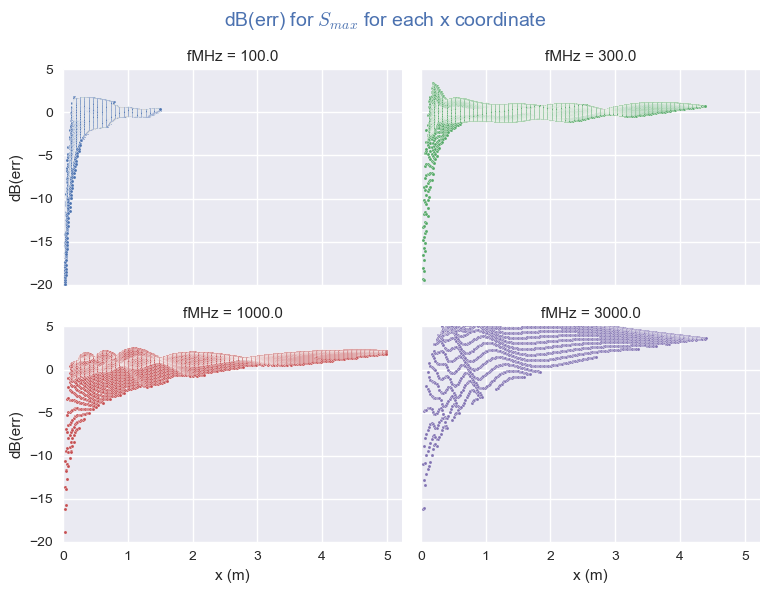

In [207]:
g = sns.FacetGrid(data=dBerrSmax,col='fMHz',col_wrap=2,
                  hue='fMHz',aspect=1.3)
g.map(sns.scatterplot,'x','value',markers=True, s=5)
g.set(xlim=(0, None),ylim=(-20,5),ylabel='dB(err)',
      xlabel='x (m)')
g.fig.suptitle('dB(err) for $S_{max}$ for each x coordinate',
               fontsize=14,color='b')
g.fig.tight_layout()
g.fig.savefig(PLOTDIR+f'dBerr scatter by fMHz_IEC.png',dpi=200);

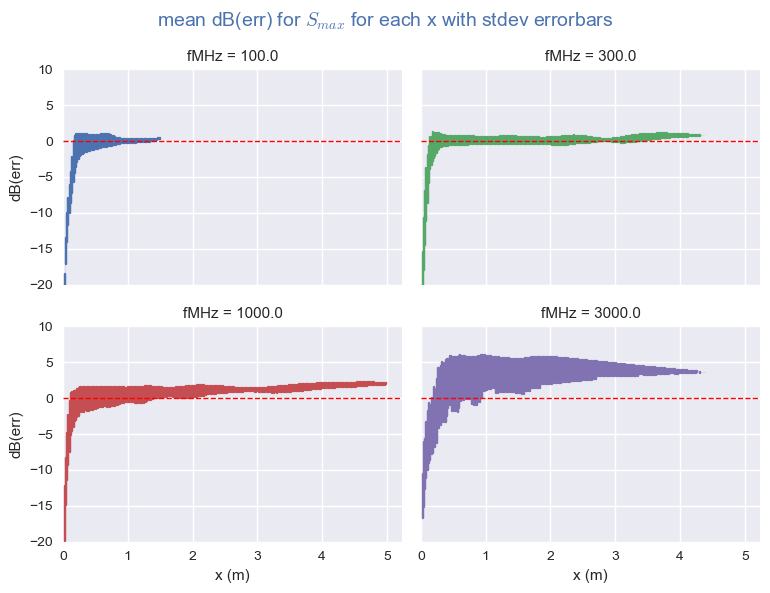

In [206]:
g = sns.FacetGrid(data=dBerrSmax,col='fMHz',col_wrap=2,
                  hue='fMHz',aspect=1.3)
g.map(sns.lineplot,'x','value',ci='sd',err_style='bars',
      markers=False,lw=0.1)
g.set(xlim=(0, None),ylim=(-20,10),ylabel='dB(err)',
      xlabel='x (m)')
for ax in g.axes:
    ax.axhline(0, lw=1, color='red', ls='--')
g.fig.suptitle('mean dB(err) for $S_{max}$ for each x with stdev errorbars',
               fontsize=14,color='b')
g.fig.tight_layout()
g.fig.savefig(PLOTDIR+f'dBerr mean & sd by fMHz_IEC.png',dpi=200);

## Scratch

In [67]:
from scipy import integrate
import numpy as np
f = lambda x: x**8
integrate.fixed_quad(f, 0.0, 1.0, n=4)

(0.1110884353741496, None)

In [68]:
v = np.array(34.5)
float(v)

34.5

In [69]:
@np.vectorize
def calcSsa2(f, a, b, n):
    print(f'{f = }\n{a=}, {b=}, {n=}, {f(a)=}, {f(b)=}')
    Ssa = integrate.fixed_quad(f, a, b, n)
    return Ssa

def GQRsa2(zps, Sps, zsa, l, n):
    '''Calculate the spatial average values using Gaussian Quadrature Rule
       INPUTS:
         zps = z values for point spatial S estimates
         Sps = point spatial S values at zps locations
         zsa = z value where GQR spatial average estimates are evaluated
         l = spatial averaging length
         n = order of Gaussian quadrature integration
       OUTPUTS:
         Ssa = GQR spatial average estimates of S at zsa locations'''
    
    # Generate interpolation function for (zps, Sps) data
    f = interpolate.interp1d(zps, Sps, kind='cubic', fill_value='extrapolate')
    a = zsa - l/2
    b = zsa + l/2
    print(f'{f = }\n{a=}\n{b=}\n{n=}\n{f(a)=}\n{f(b)=}')

    # Calculate spatial average
    fixed_quad_vec = np.vectorize(integrate.fixed_quad)
    Ssa = fixed_quad_vec(f, a, b, n)
    # Ssa = calcSsa2(f, a, b, n)

    return Ssa

In [ ]:
def GQRsa(pts,wts,zps,Sps,zsa):
    '''Calculate the spatial average values using Gaussian Quadrature Rule
       INPUTS:
         pts = GQR point locations
         wts = GQR weights
         zps = z values for point spatial S estimates
         Sps = point spatial S values at zps locations
         zsa = z values where GQR spatial average estimates are evaluated
       OUTPUTS:
         Ssa = GQR spatial average estimates of S at zsa locations'''
    
    # Generate interpolation function for (zps, Sps) data
    f = interpolate.interp1d(zps, Sps, kind='cubic', fill_value='extrapolate')

    @np.vectorize
    def calcSsa(z):
        zGQR = z + pts
        SGQR = f(zGQR)
        S = (wts * SGQR).sum() / 2
        return S
    
    Ssa = calcSsa(zsa)
    
    return Ssa
